In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.style as style
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
style.use('seaborn-colorblind')
plt.rcParams.update({'font.size':10})
from sklearn.datasets import fetch_openml
np.set_printoptions(suppress=True, precision=5)
import random

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist['data'].reshape(-1, 28, 28) / 255.0  # shape: (70000, 28, 28)
y = mnist['target'].astype(int)

In [165]:
class InhibitedNeuronLayer:
    """
    Instead of a single neuron, this class represents a layer of N neurons
    This layer is inhibited - the spiking of a single neuron sets the voltages of all other neurons to the reset value
    Each neuron has a voltage, input current, voltage threshold, threshold increment theta, theta decay rate, and spiking value
    These are stored in arrays
    """
    def __init__(self, N, tau=100, v_reset=0.0, v_thresh=500, theta=10.0, tau_theta=0.001):
        self.size = N                                   # Size of the layer
        self.tau = tau                                # Decay rate
        self.v_reset = v_reset                          # Reset potential after spike
        self.v_thresh0 = v_thresh                       # Relaxed threshold potential
        self.v_thresh = np.full(N,v_thresh,dtype=float) # Threshold potentials
        self.theta = theta                              # Amount to increment threshold potential after spike
        self.tau_theta = tau_theta                      # Theta decay rate
        self.v = np.full(N,v_reset,dtype=float)         # Initial potentials
        self.spike = np.full(N,False)                   # Spike flags (0|1)

    def step(self, input_currents):
        """Simulate one time step with input currents.
            The input current shoud be a 1d numpy array with shape N"""
        self.v += -self.v/self.tau + input_currents

        # Check for spike
        self.spike = self.v >= self.v_thresh                           #spike if voltage is greater than threshold voltage
        if np.any(self.spike):
            self.v[:] = self.v_reset # set voltage of all neurons to reset voltage for spike event
            self.v_thresh[self.spike==True] += self.theta                  #alter the voltage threshold for any neurons that have just spiked
        self.v_thresh += (self.v_thresh0-self.v_thresh)*self.tau_theta #relax the voltage threshold back to the initial value

        return self.v, self.spike

    def static_step(self, input_currents):
        """Simulate one time step with input currents.
            The input current shoud be a 1d numpy array with shape N
            This is the same as the 'step' function but does not update the voltage thresholds of any of the neurons"""
        self.v += -self.v/self.tau + input_currents

        # Check for spike
        self.spike = self.v >= self.v_thresh                           #spike if voltage is greater than threshold voltage
        if np.any(self.spike):
            self.v[:] = self.v_reset # set voltage of all neurons to reset voltage for spike event

        return self.v, self.spike

    def reset(self):
        """Reset neuron voltages to their resting values after a digit has been presented
        """
        self.v[:] = self.v_reset

class SynapseLayer:
    """
    This represents a layer of synapses connecting two different layers of neurons
    Synaptic weights update according to the STDP rule
    The synapse layer has an input size and output size
    Individual synapses have a learning rates, a minumum and maximum weight value, and a spike duration
    They exist as a matrix of weights of dimensions input_size X output_size
    Initial weights are set to random values around half the max weight
    """
    def __init__(self, input_size, output_size, alpha_plus, alpha_minus, beta, min_weight=0, max_weight=1,spike_duration=25):
        self.min_weight = min_weight                                                     # Minumum synaptic weight
        self.max_weight = max_weight                                                     # Maximum synaptic weight
        self.weights = np.clip(np.random.normal(0,0.25,(input_size,output_size))+max_weight/2,min_weight,max_weight) # Initialize layer weights
        self.beta = beta                                                                 # STDP exponential factor
        self.input_size = input_size                                                     # Size of input
        self.output_size = output_size                                                   # Size of output
        self.input_spike_trace = np.zeros(self.input_size,dtype=int)        # spike traces
        self.alpha_plus = alpha_plus                                                     # amount to increase synaptic weights
        self.alpha_minus = alpha_minus #amount to decrease synaptic weights
        self.spike_trace_ages = np.zeros(self.input_size,dtype=int)        # age of spike traces
        self.spike_duration = spike_duration #duration of spike

    def update_weights(self, input_spikes, output_spikes):
        """Simulate one time step and any subsequent weight updates
           Takes pre and post synaptic spiking data as inputs to update pre and postsynaptic traces as well as weights"""
        #handle spiking events and updating spike traces
        self.spike_trace_ages[:]+=1
        self.input_spike_trace[self.spike_trace_ages>self.spike_duration]=0
        self.input_spike_trace[input_spikes==True]=1
        self.spike_trace_ages[input_spikes==True]=0
        # print(self.input_spike_trace)
        # print(self.weights)
        # print(self.weights[self.input_spike_trace==1,output_spikes==True])
        # print(self.weights[self.input_spike_trace==0,output_spikes==True])
        modify_up=np.outer(self.input_spike_trace==True,output_spikes).astype(bool)
        self.weights[modify_up]+=self.alpha_plus*np.exp(-self.beta*(self.weights[modify_up]-self.min_weight)/(self.max_weight-self.min_weight))
        modify_down=np.outer(self.input_spike_trace==False,output_spikes).astype(bool)
        # print(modify_up)
        # print(modify_down)
        self.weights[modify_down]+=self.alpha_minus*np.exp(-self.beta*(self.max_weight-self.weights[modify_down])/(self.max_weight-self.min_weight))
        
        self.weights=np.clip(self.weights,self.min_weight,self.max_weight) #make sure weights are between min and max values
        return None
        
    def step(self):
        """Simulate one time step without any weight updates"""
        #handle updating spike traces
        self.spike_trace_ages[:]+=1
        
        return None

    def reset(self):
        """Reset pre- and postsynaptic traces to their resting values after a digit has been presented
        """
        self.input_spike_trace[:] = 0
        self.spike_trace_ages[:] = 0

In [143]:
"""
now try to learn the patterns of a more complicated system: handwritten digits
"""
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist['data'].reshape(-1, 28, 28) / 255.0  # shape: (70000, 28, 28)
y = mnist['target'].astype(int)

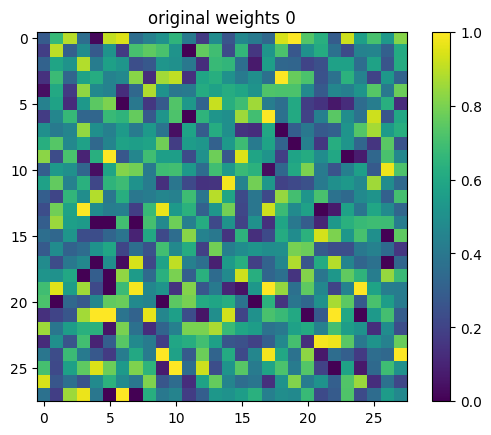

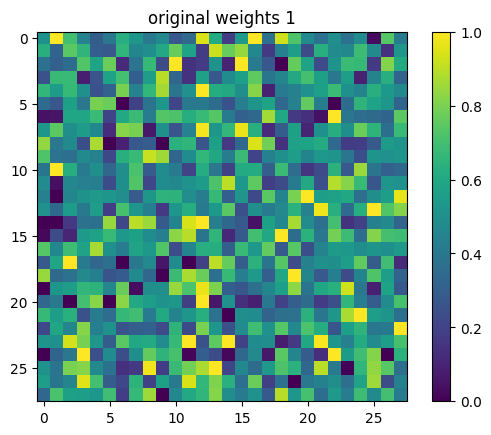

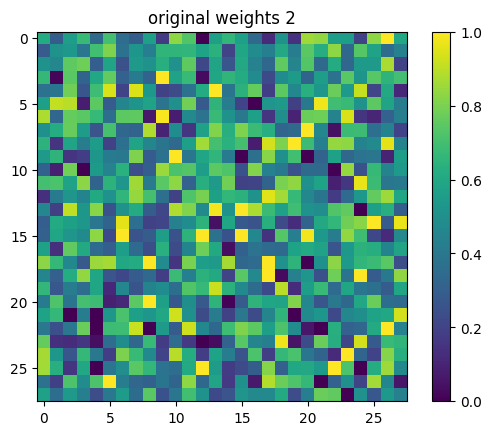

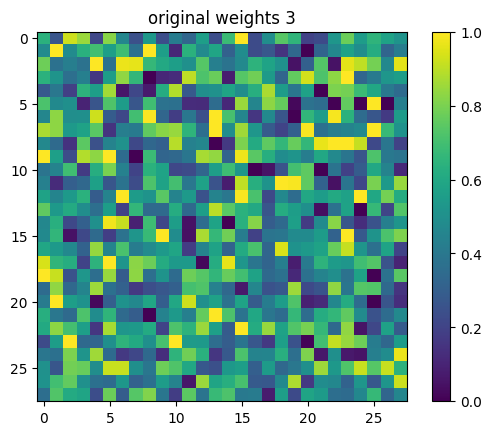

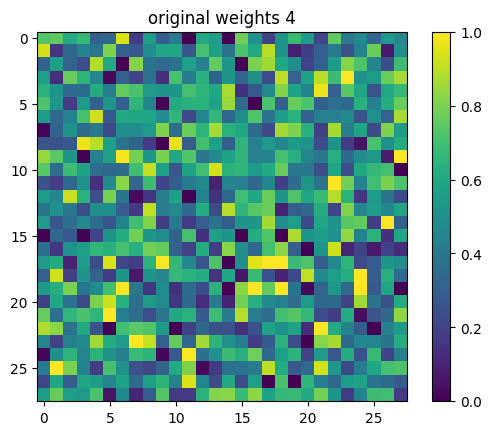

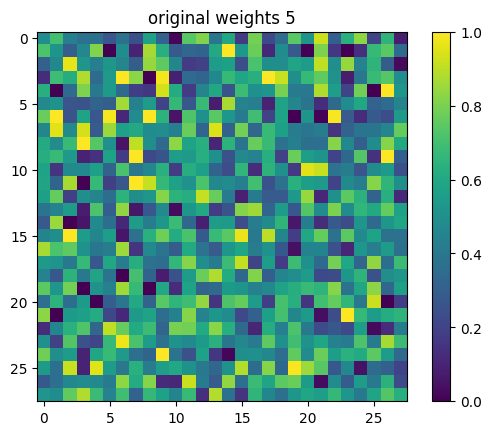

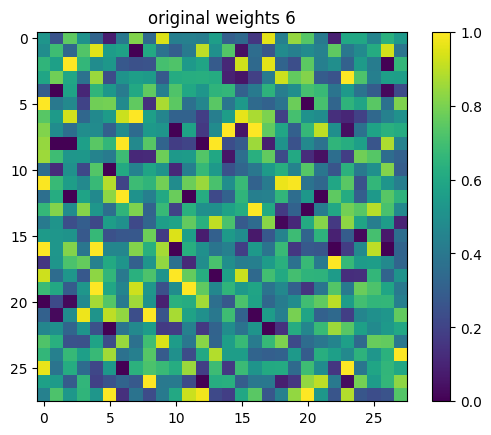

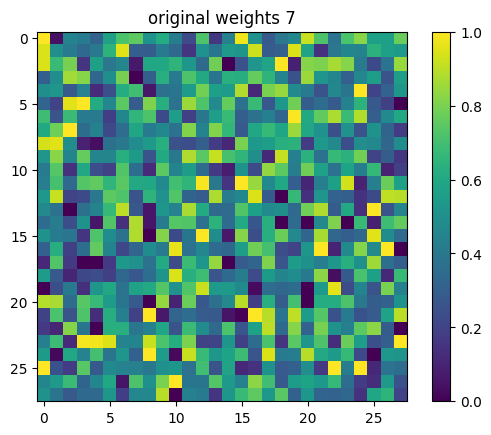

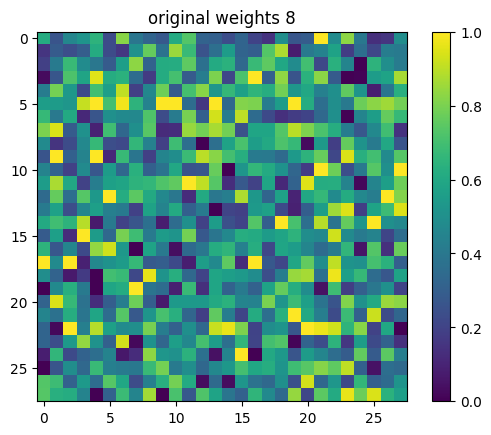

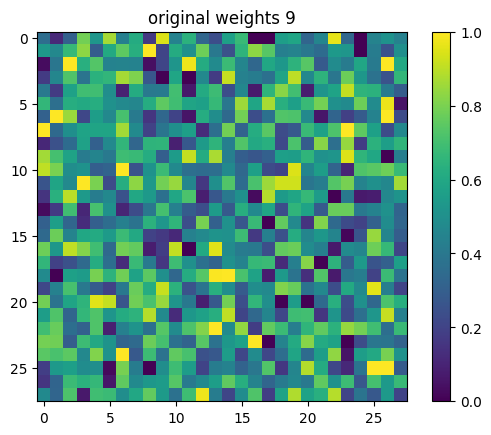

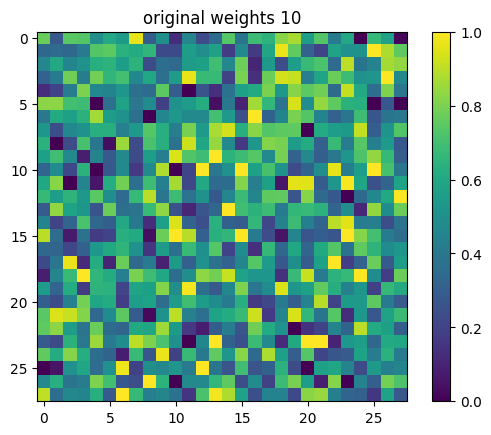

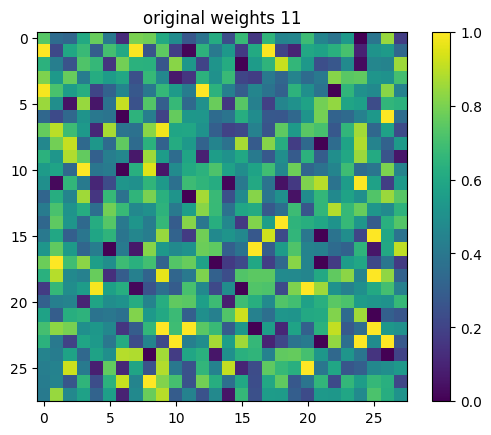

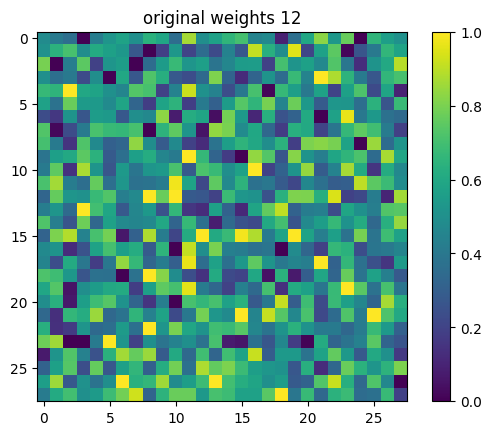

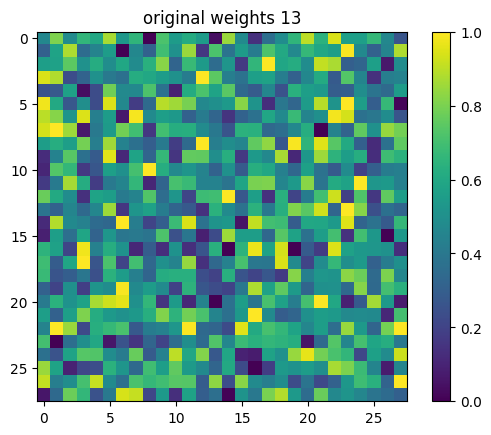

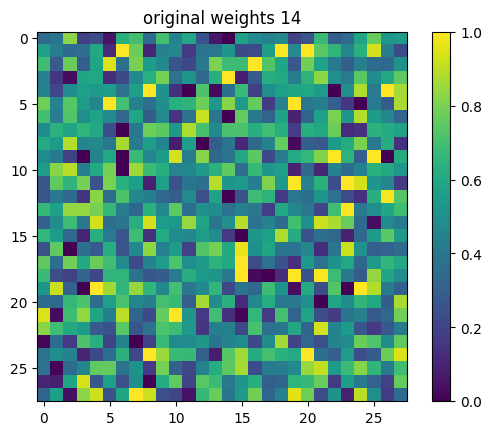

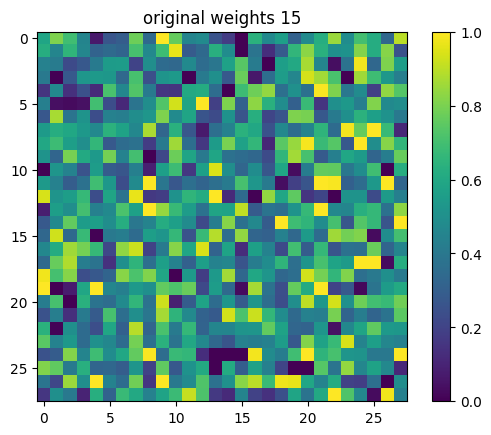

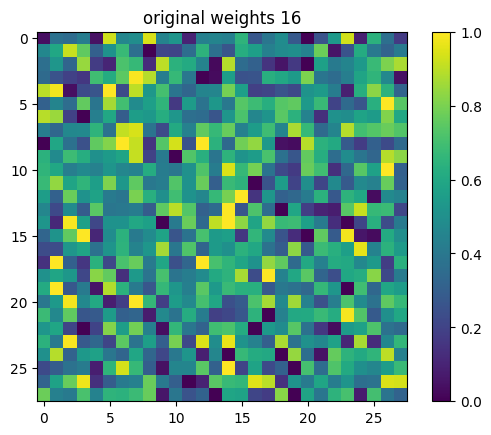

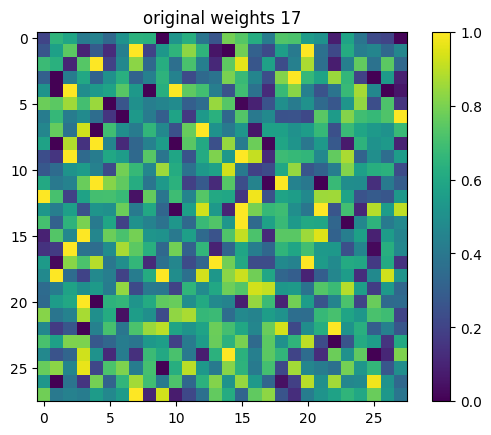

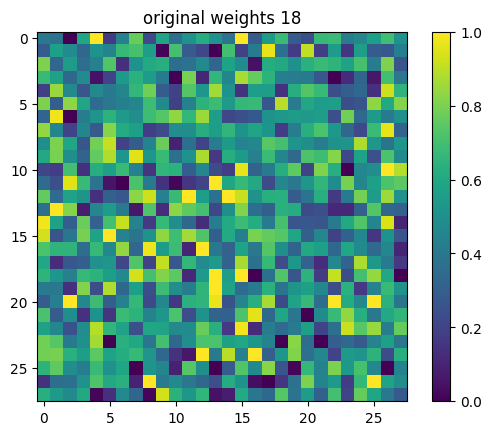

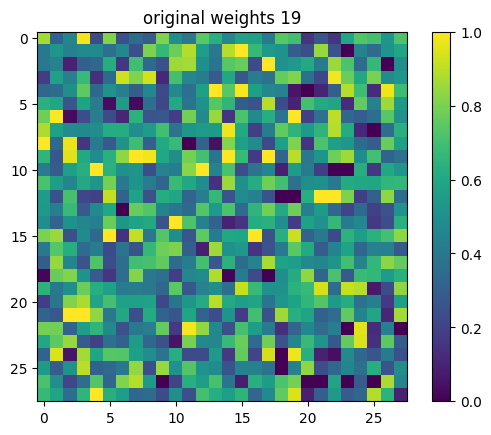

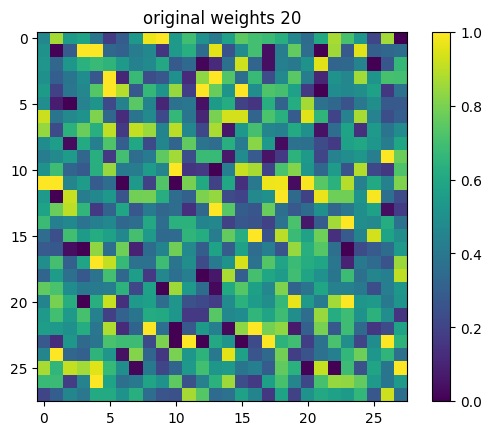

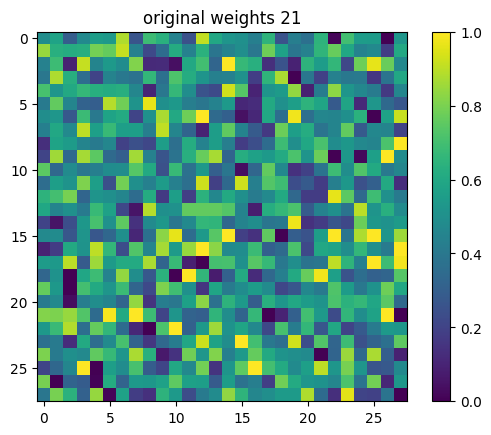

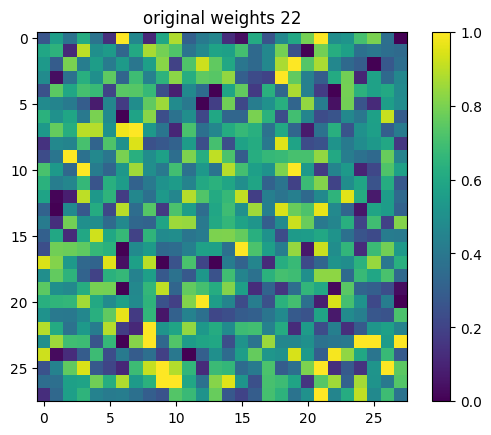

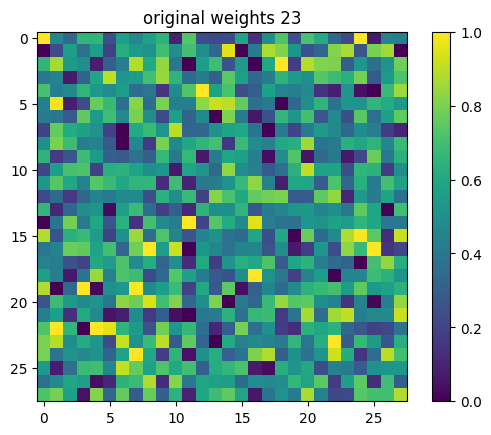

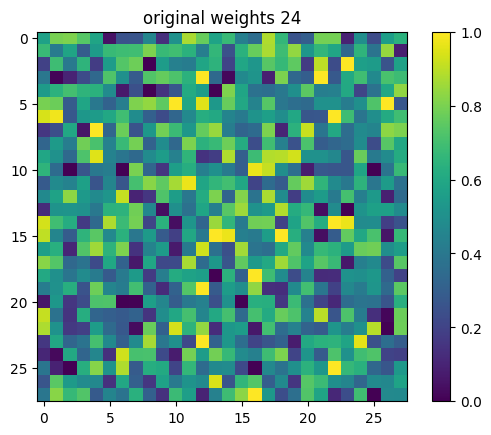

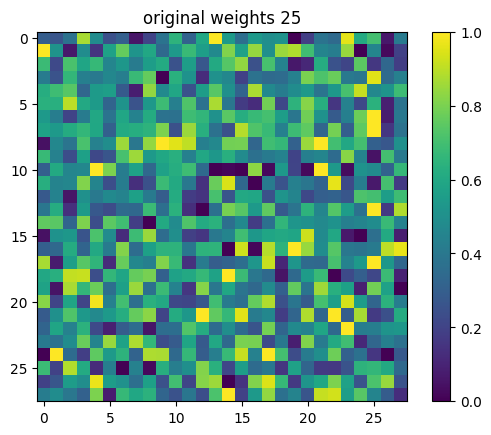

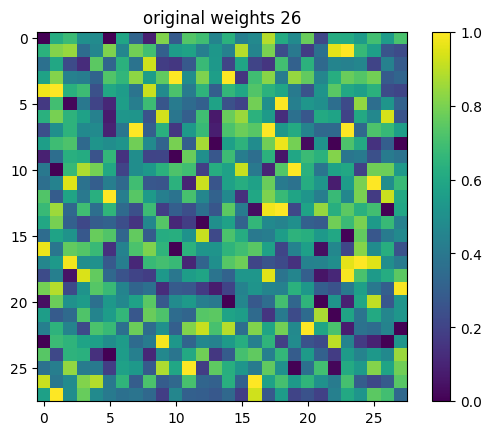

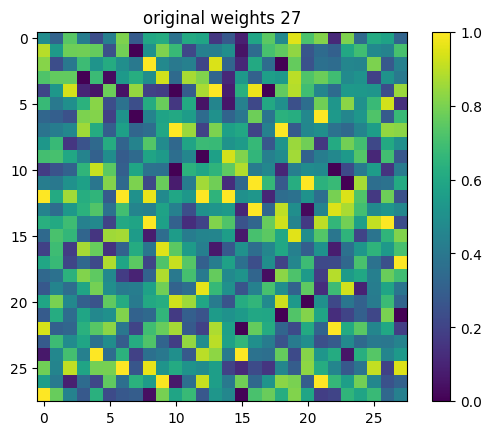

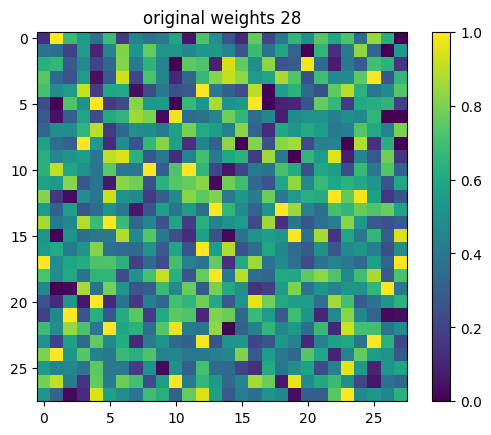

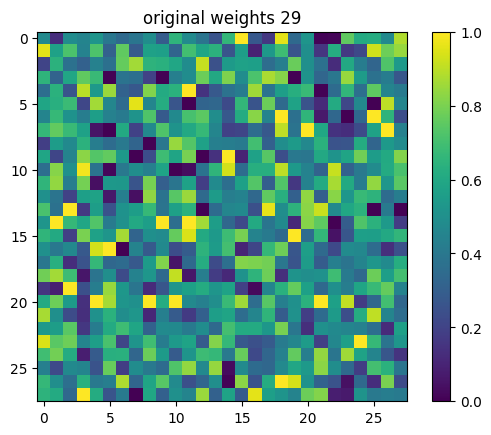

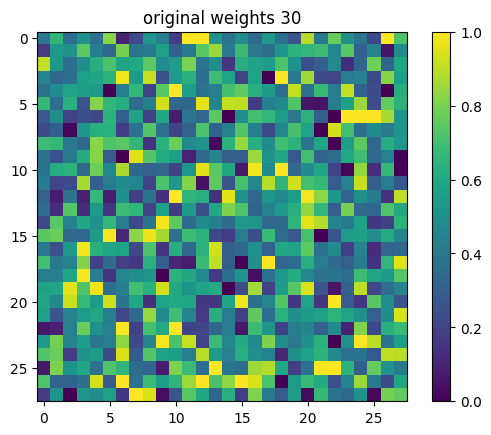

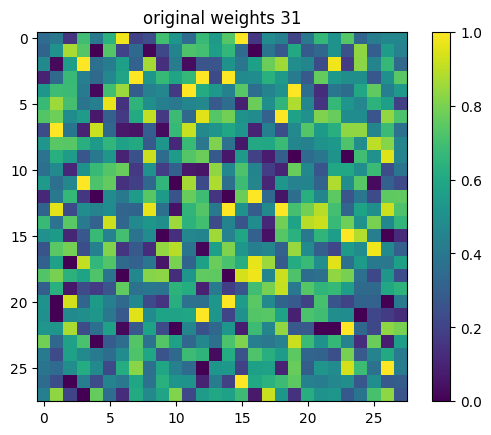

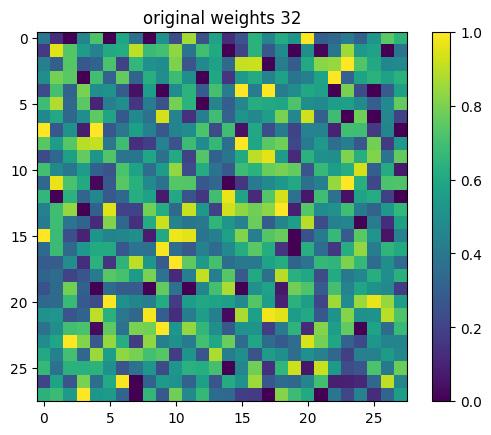

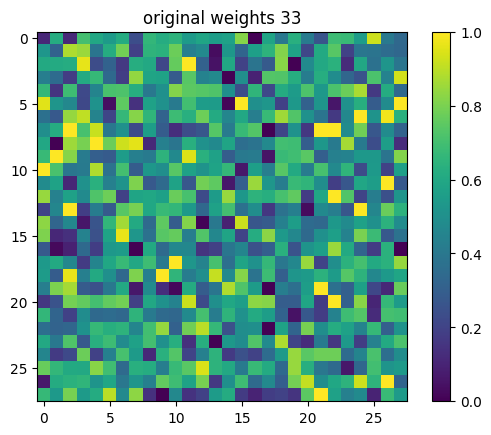

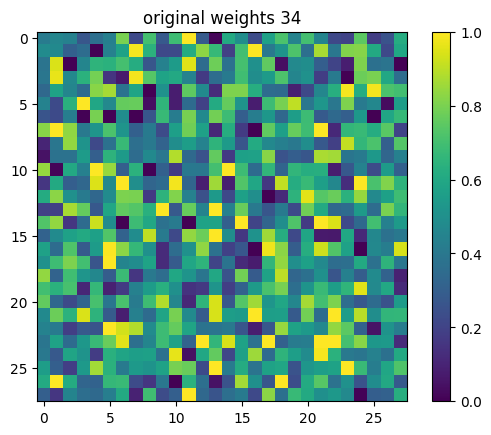

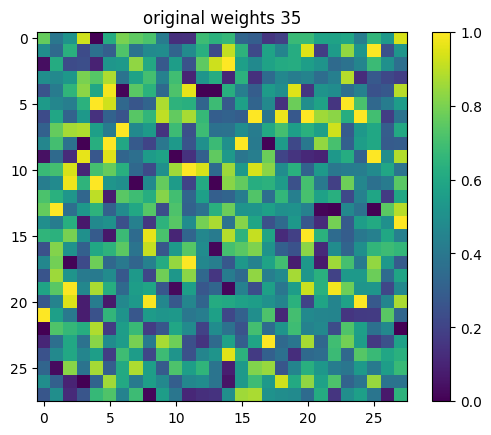

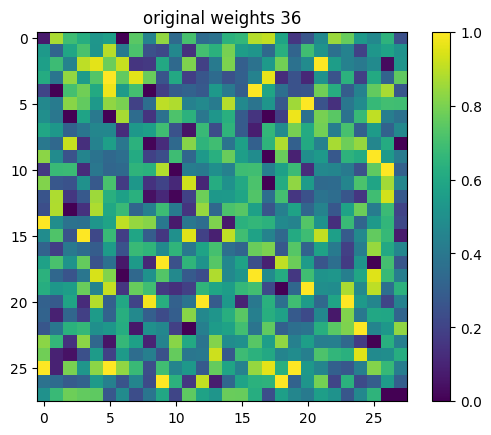

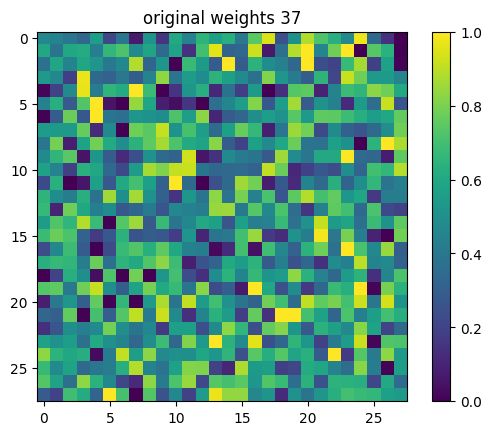

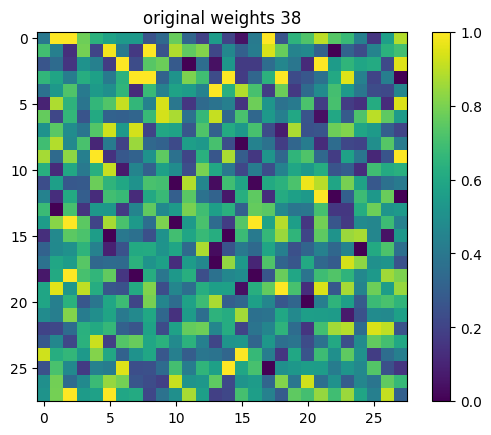

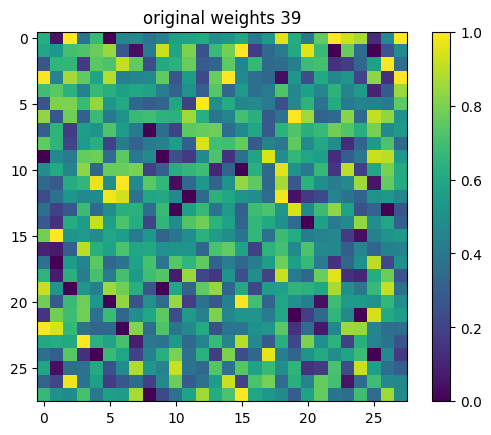

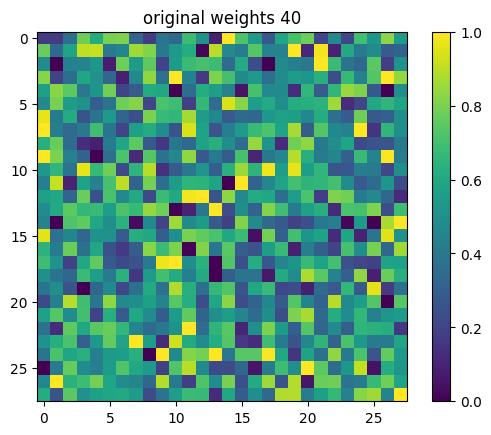

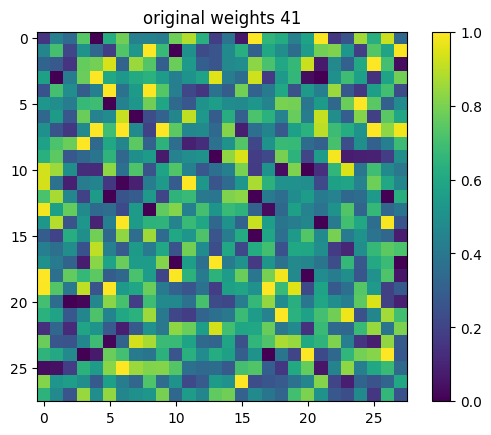

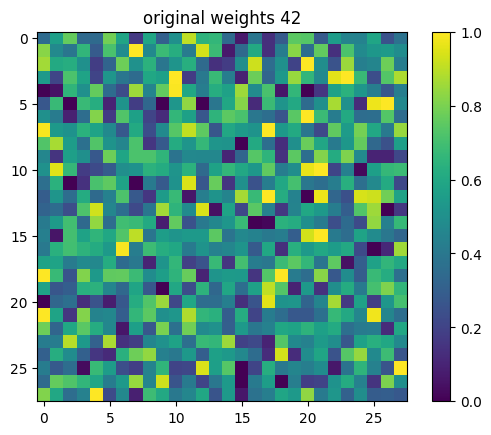

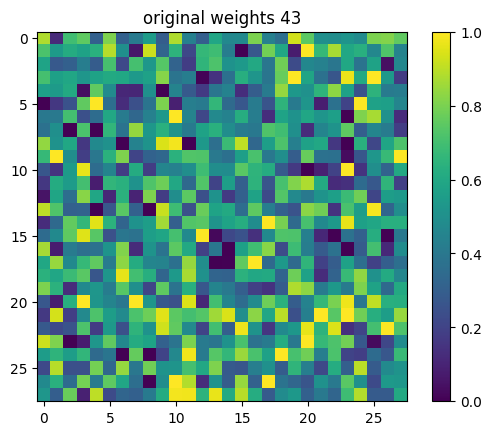

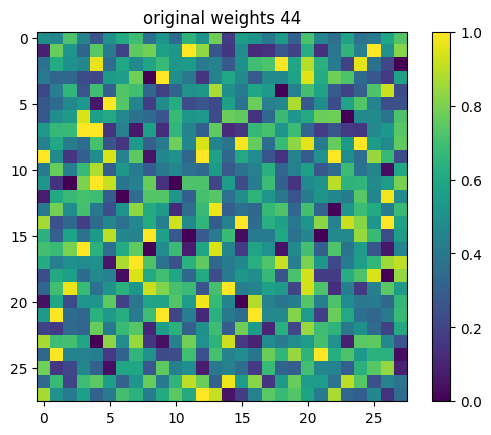

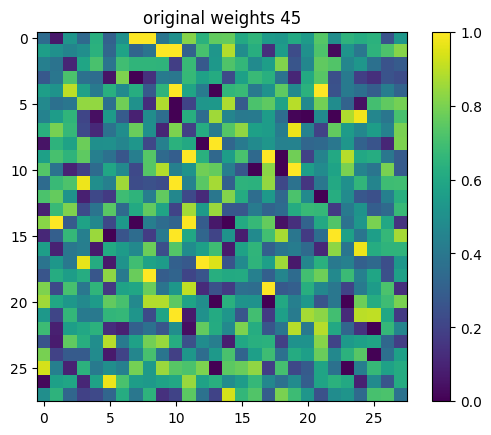

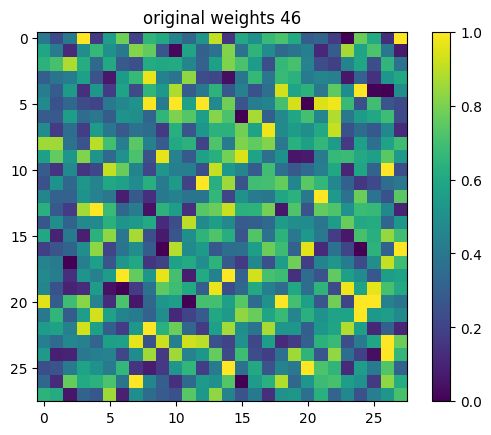

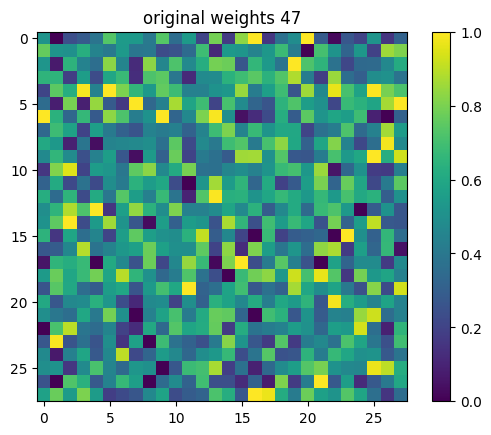

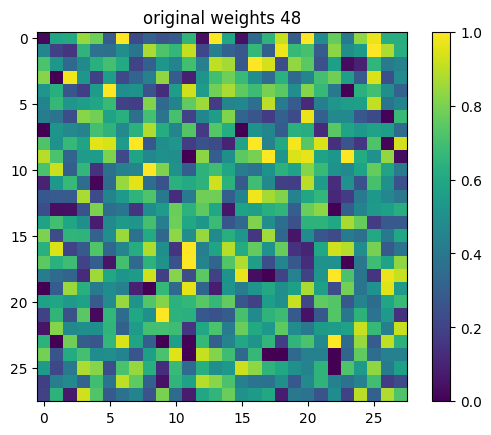

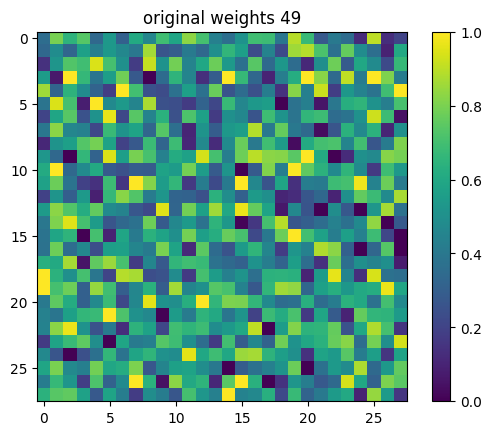

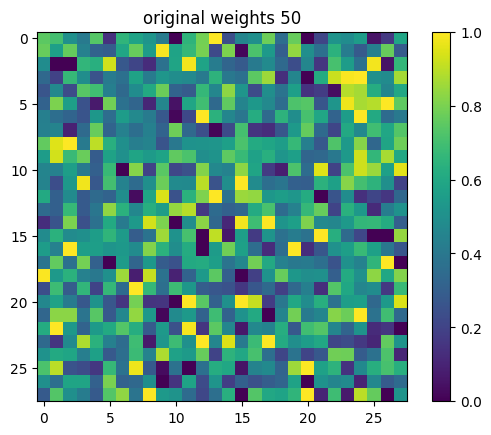

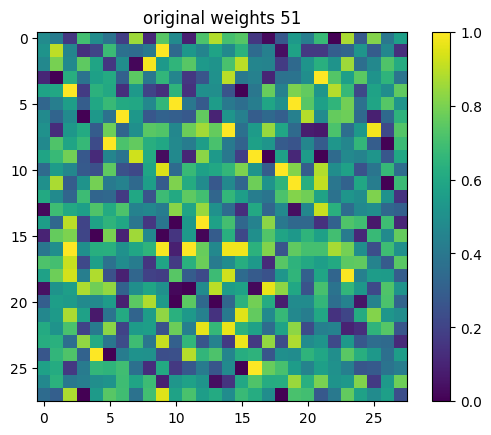

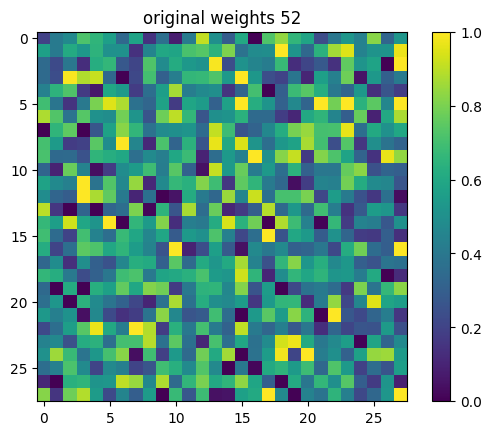

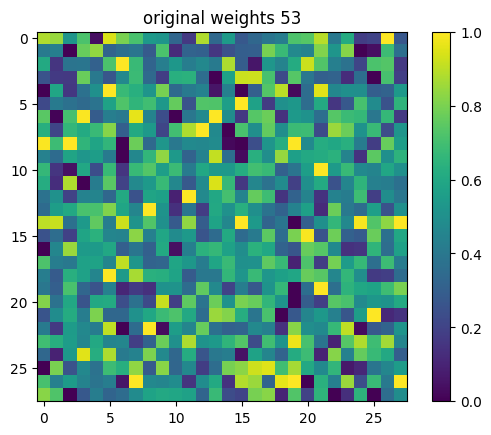

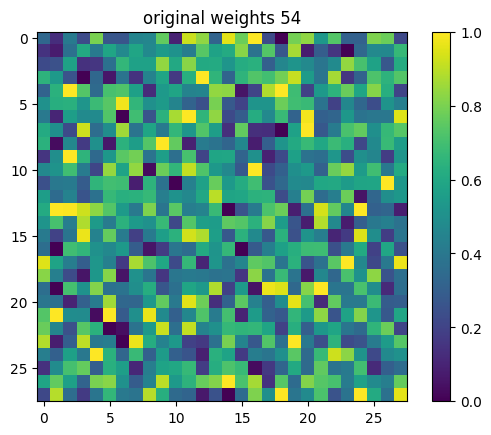

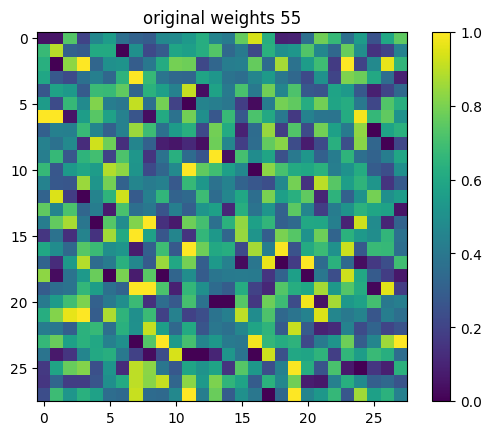

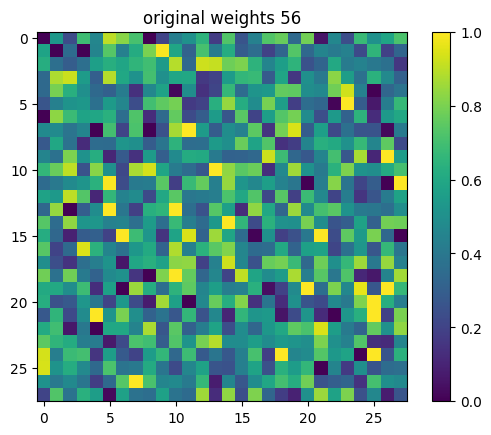

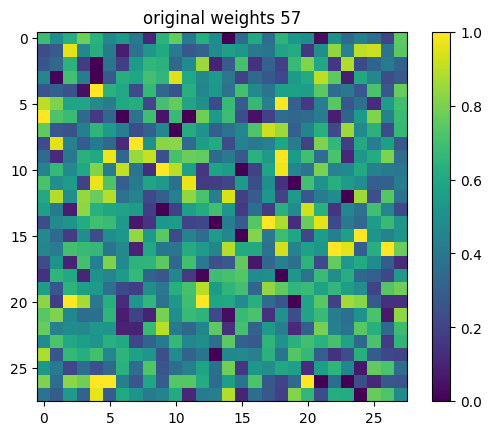

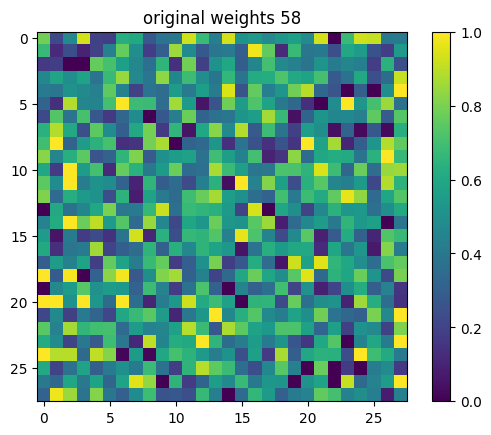

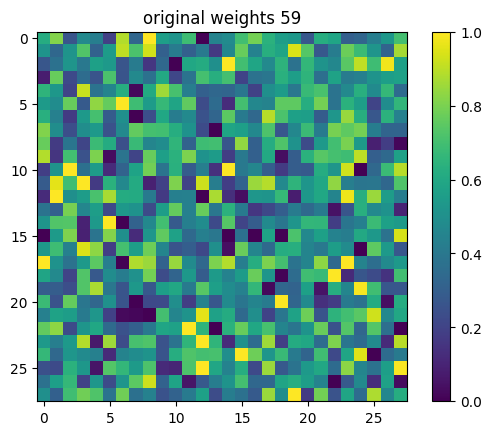

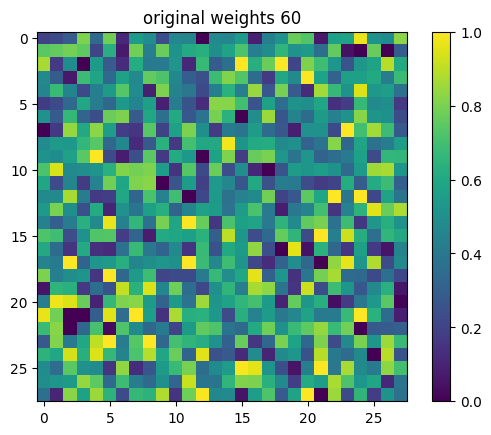

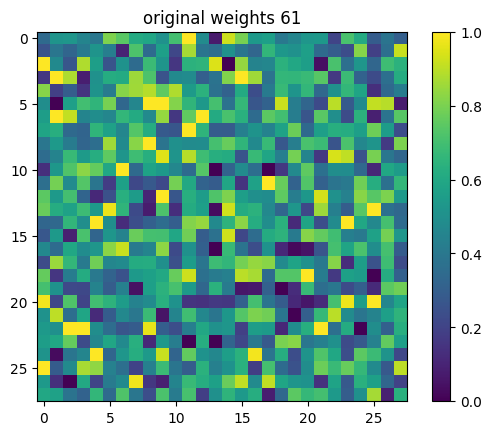

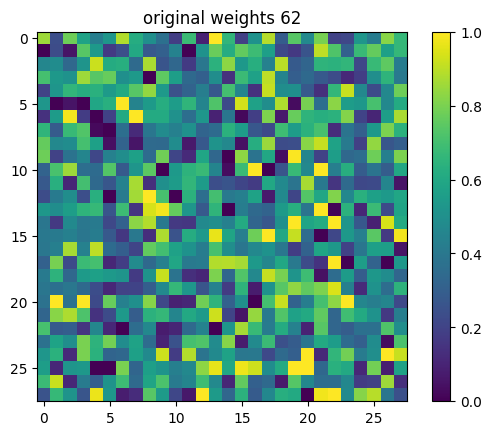

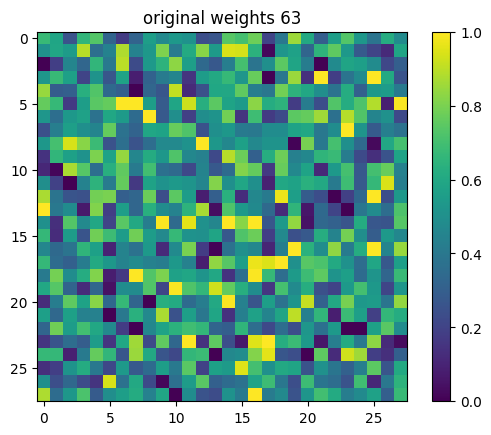

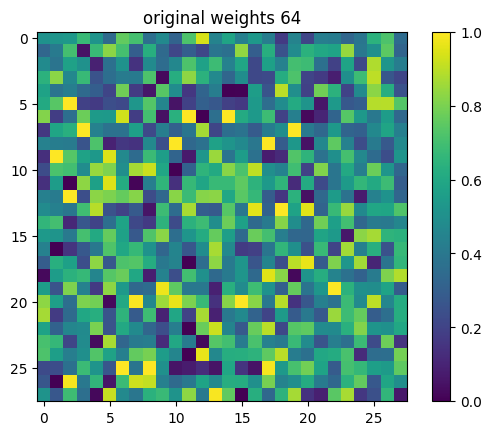

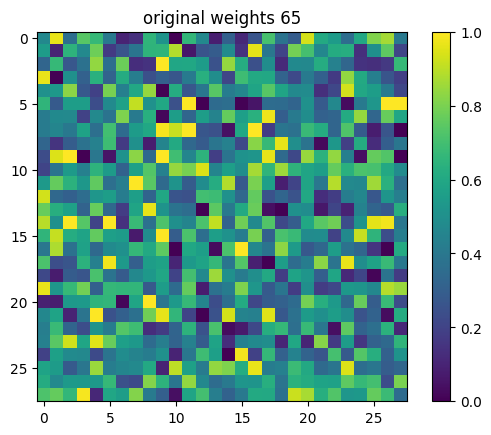

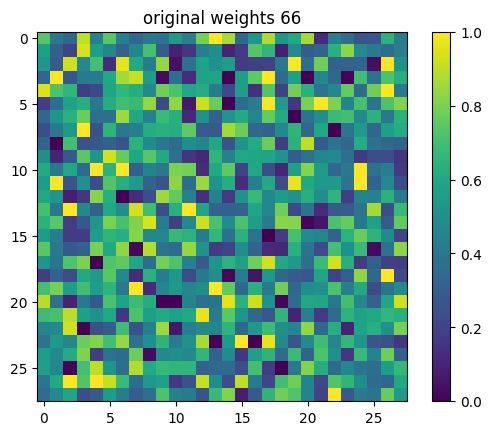

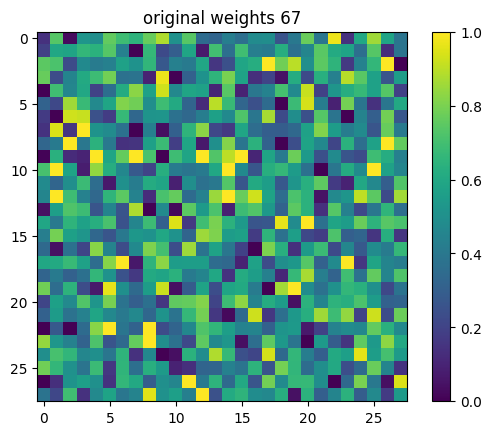

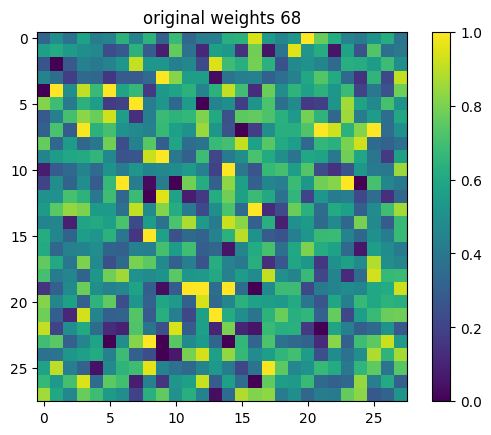

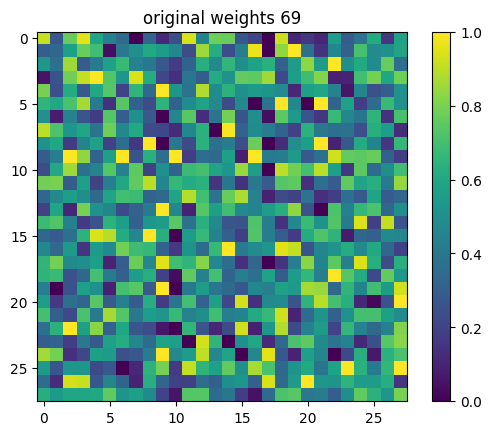

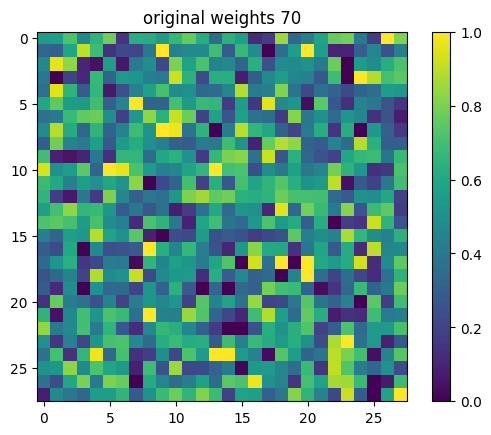

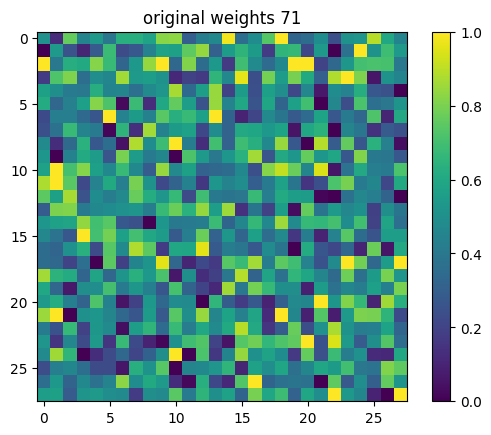

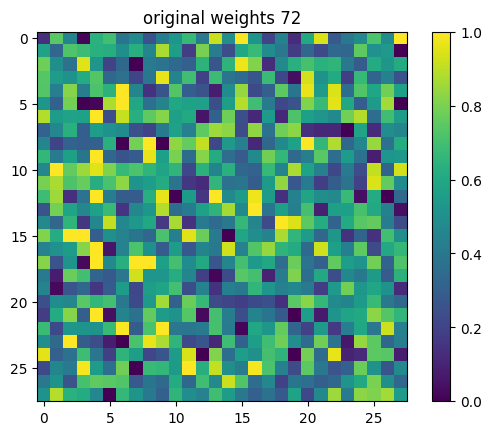

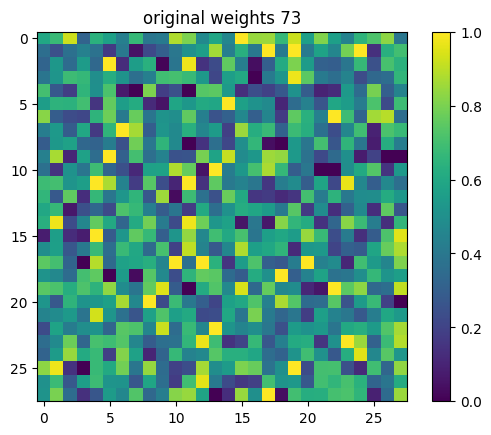

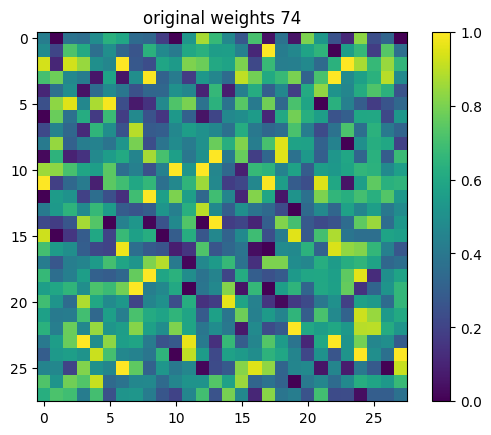

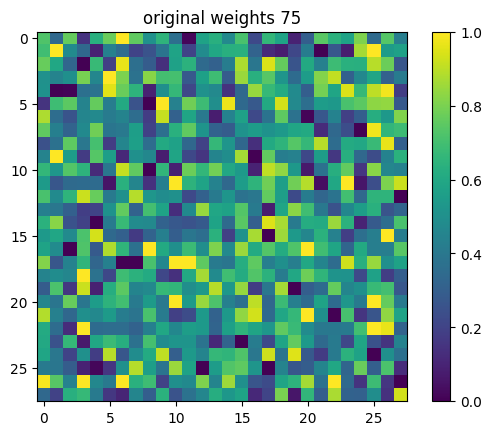

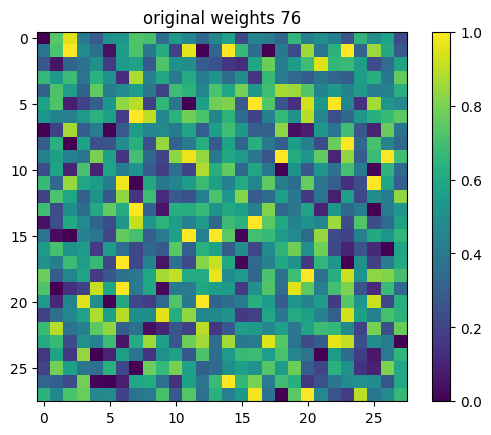

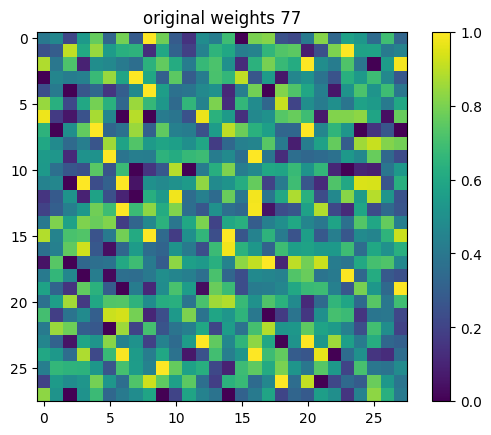

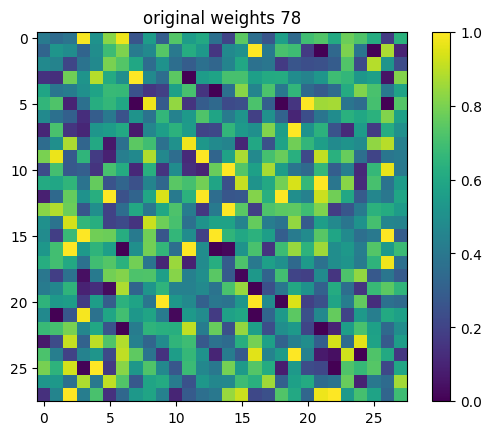

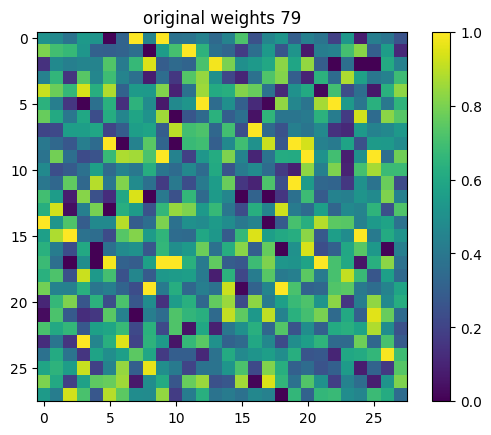

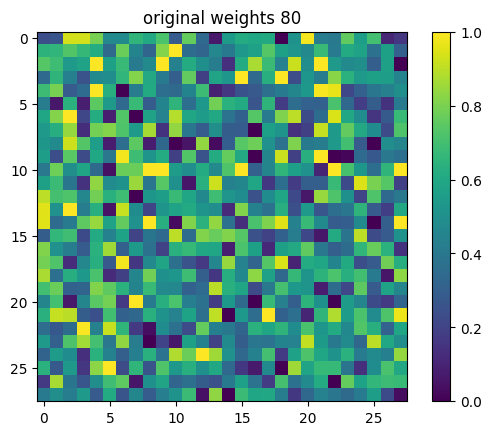

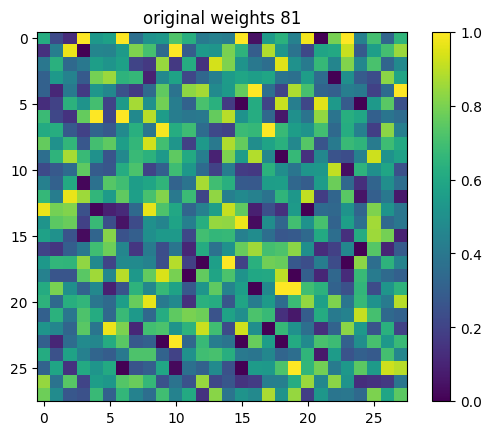

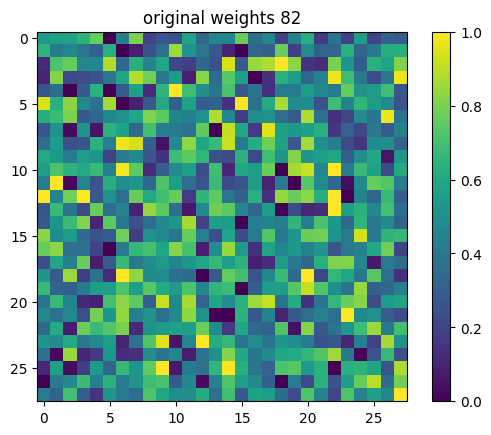

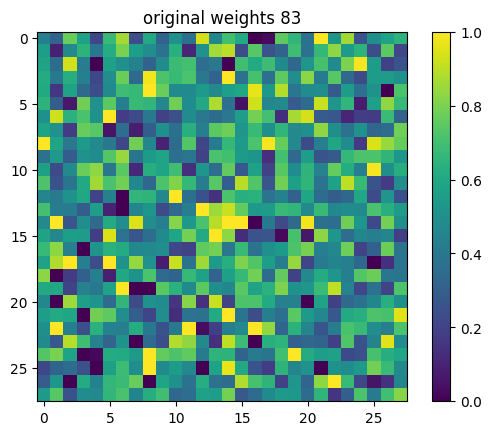

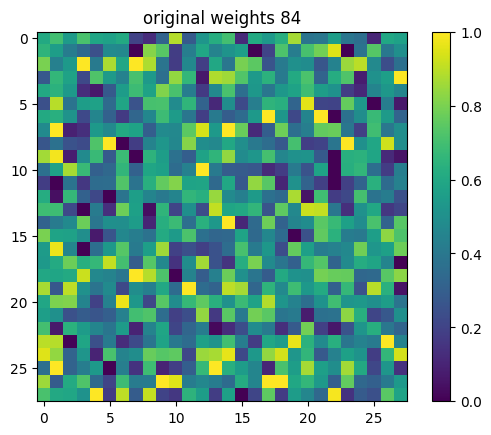

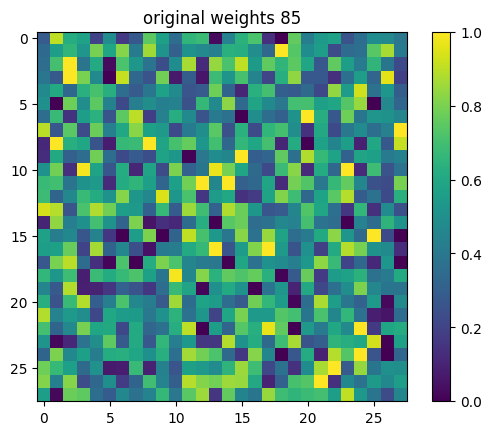

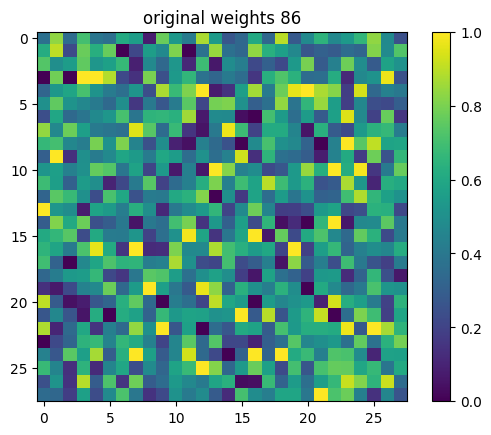

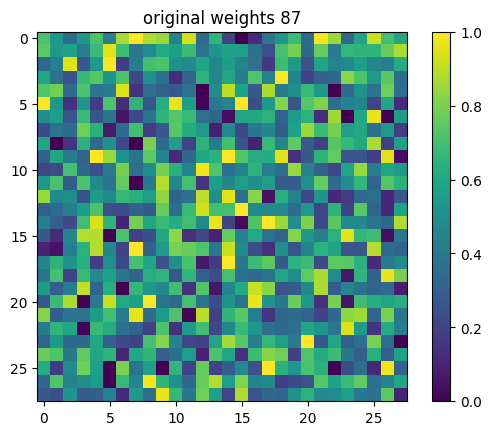

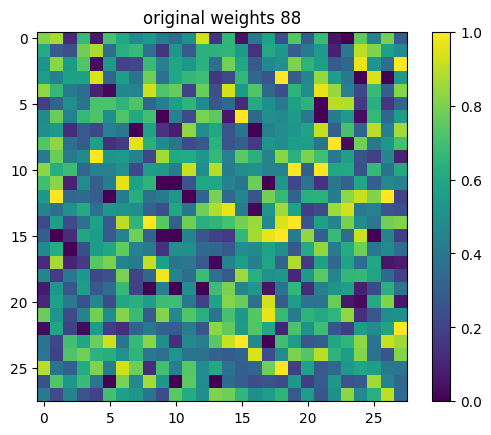

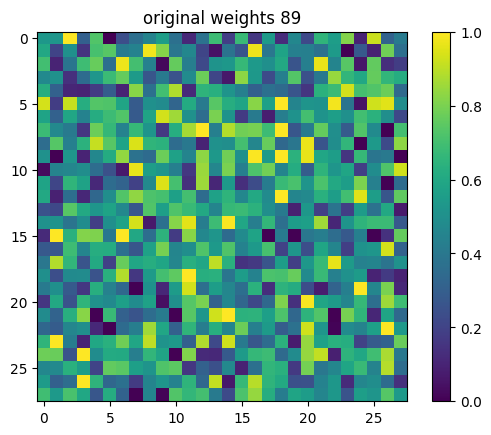

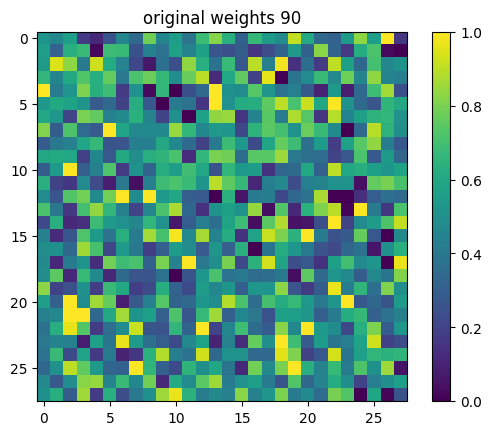

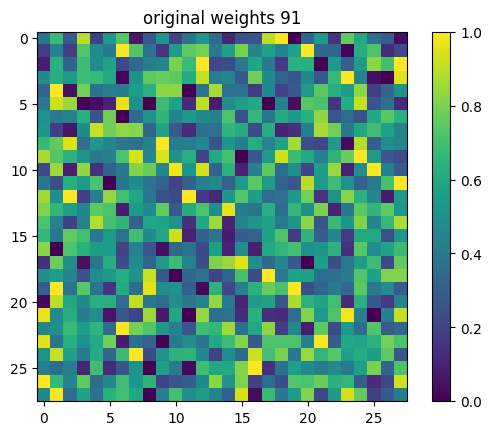

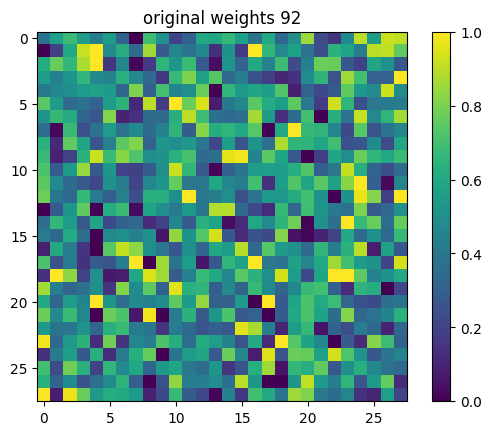

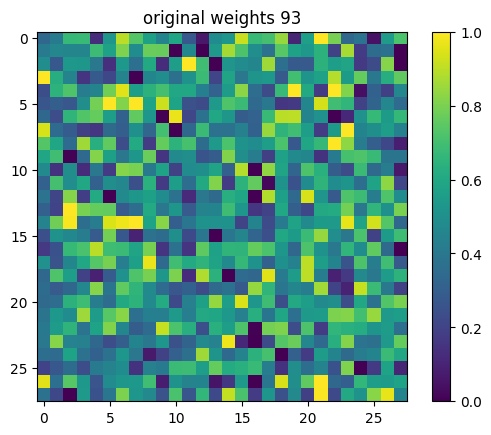

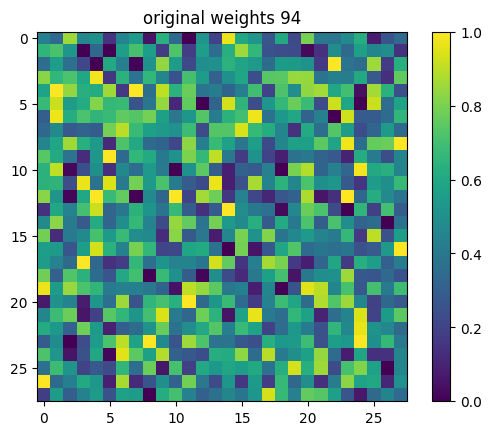

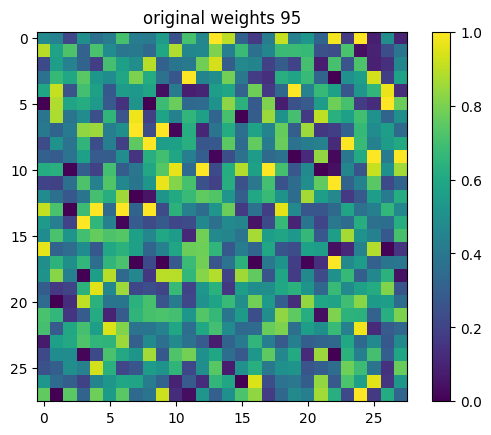

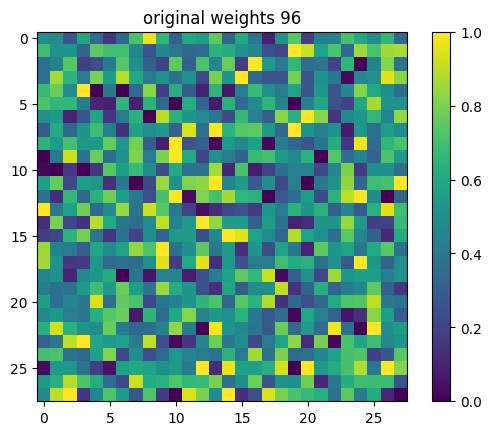

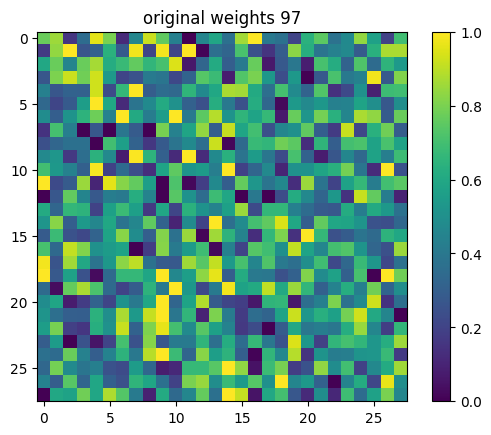

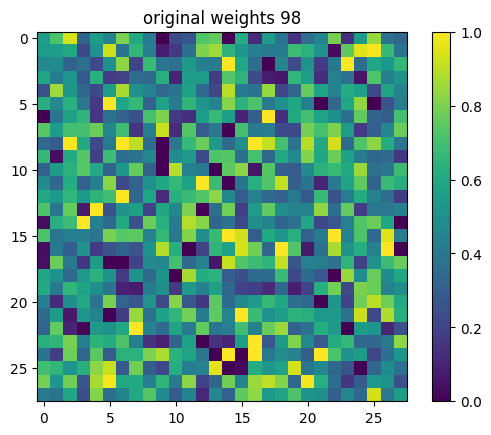

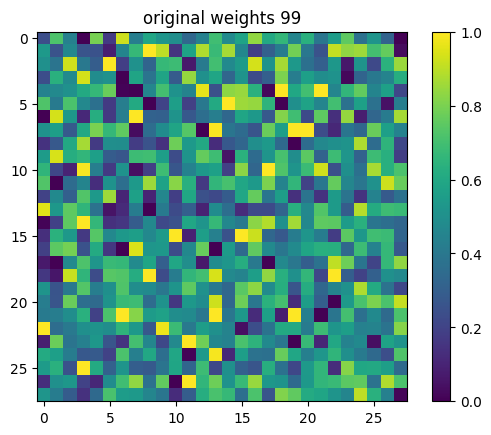

digits presented:  [5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]


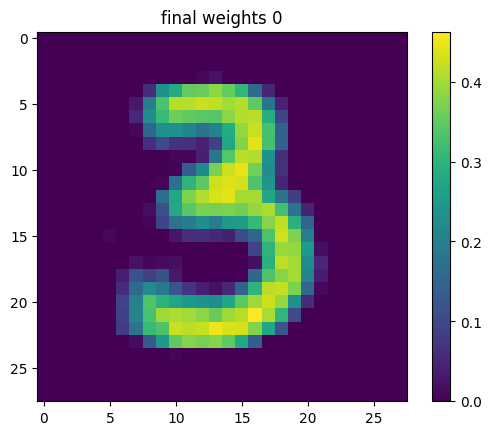

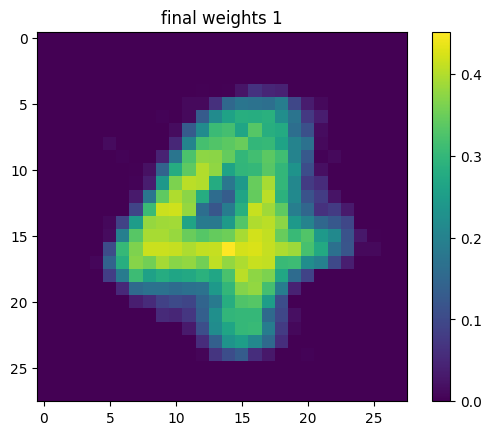

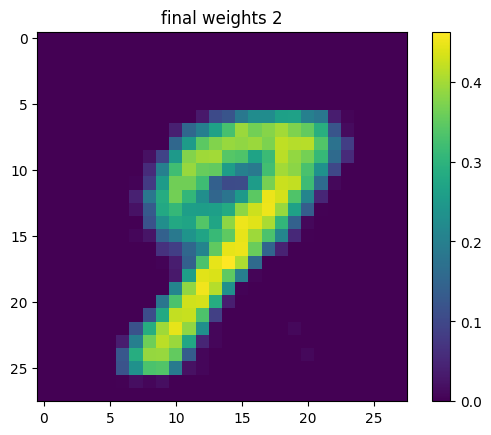

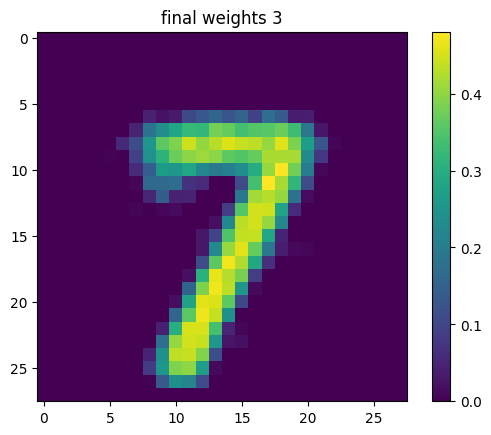

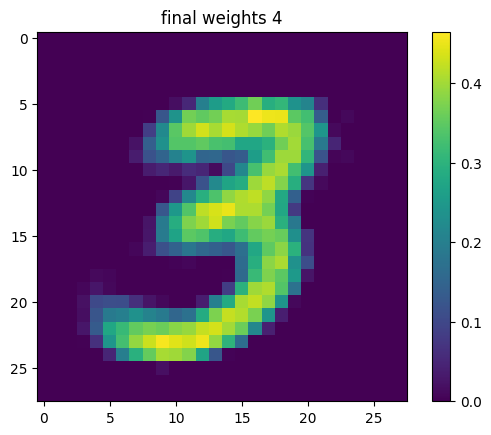

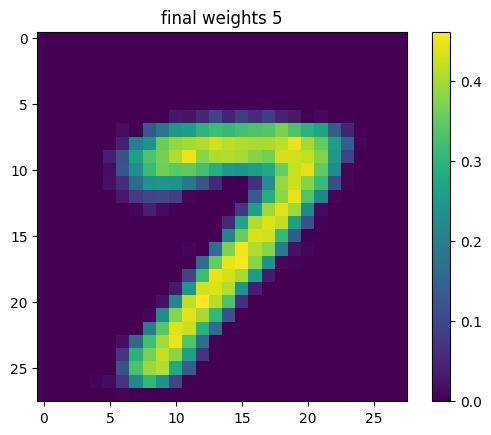

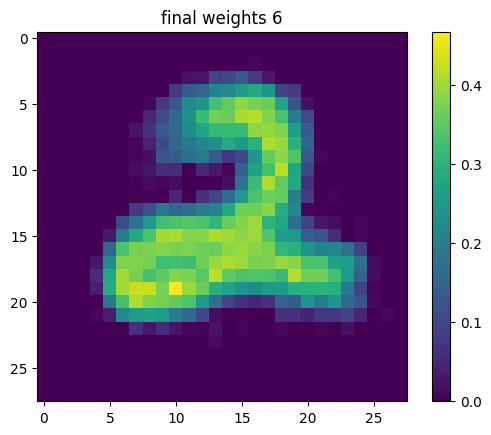

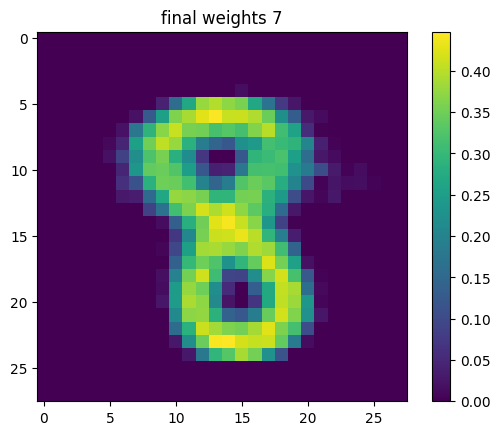

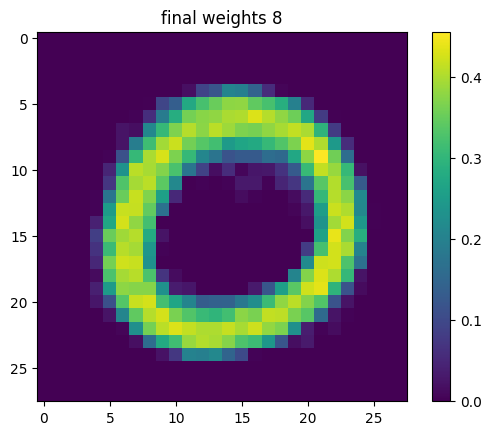

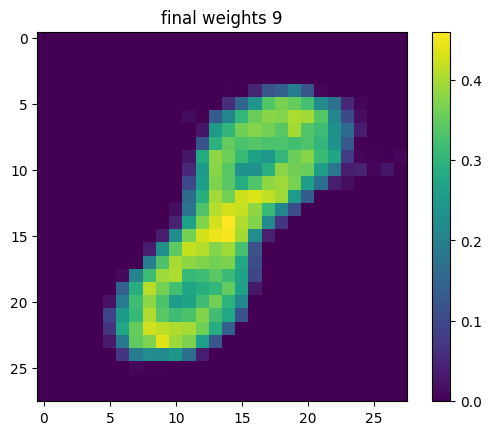

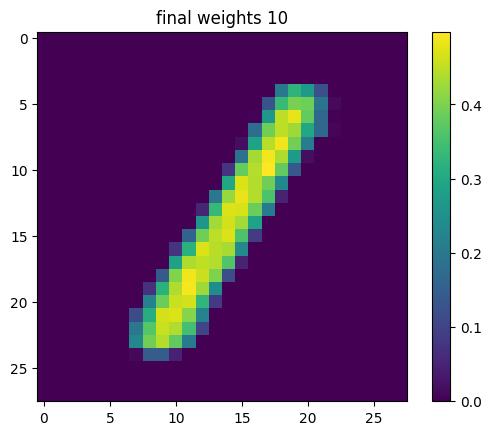

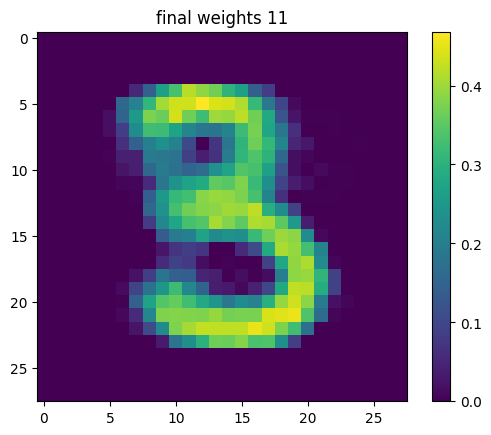

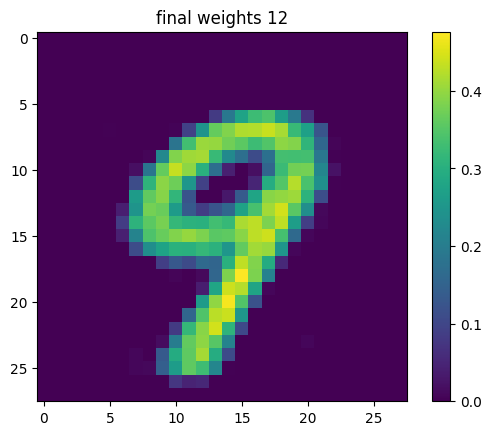

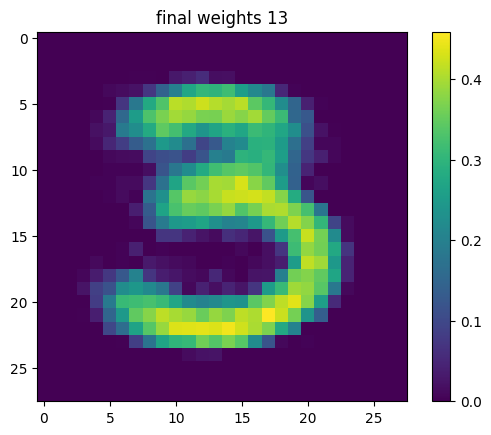

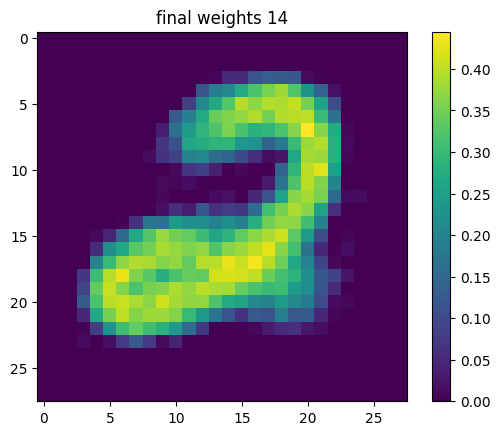

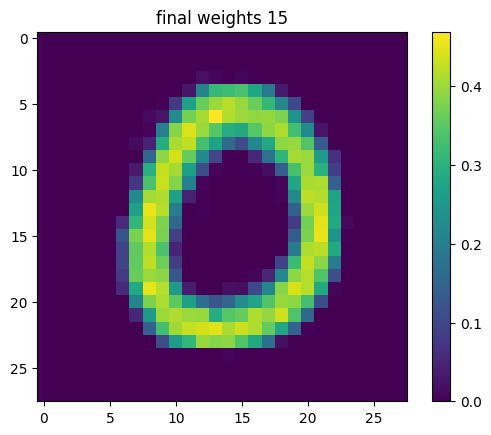

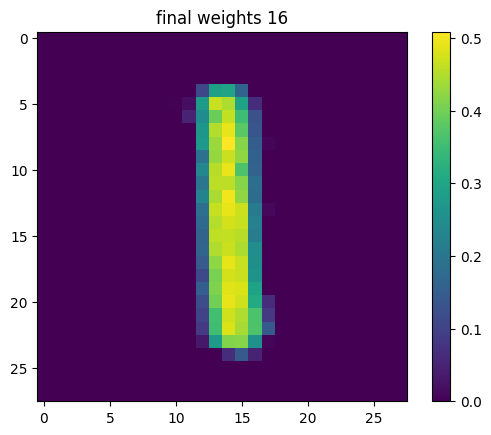

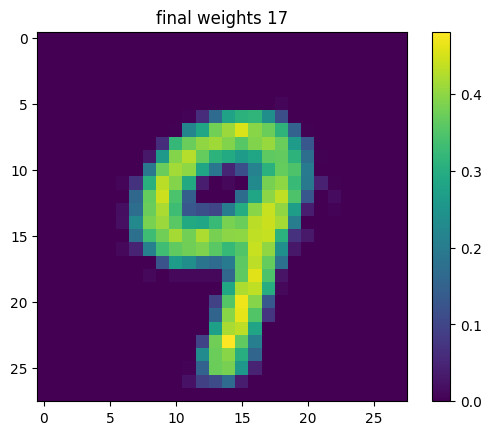

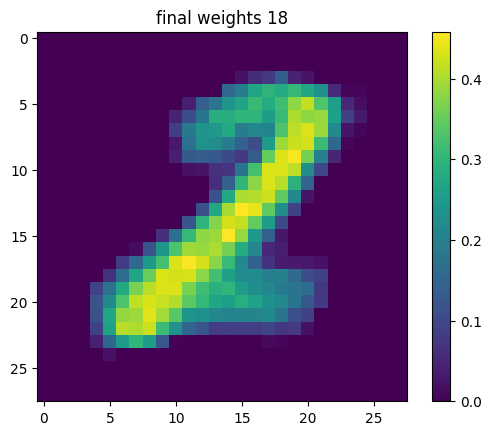

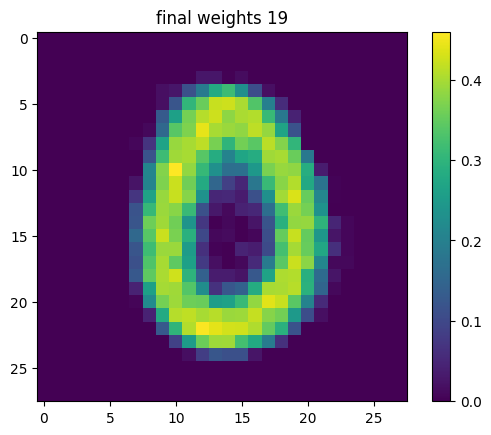

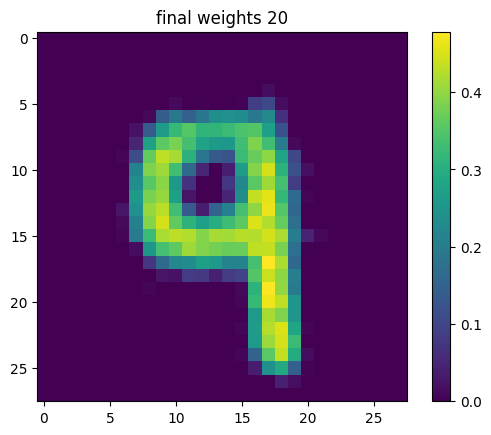

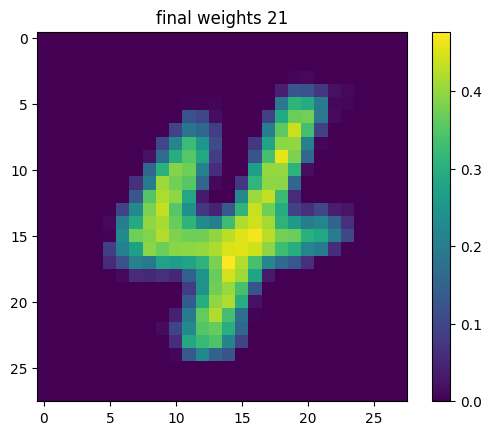

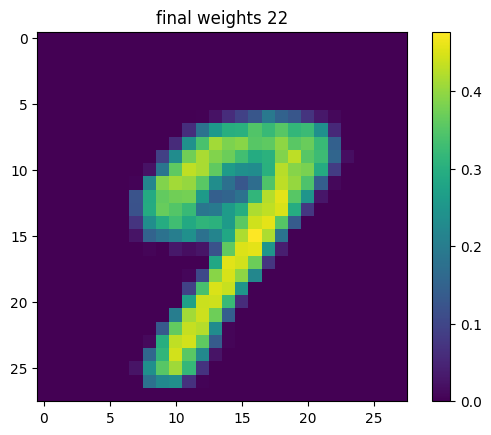

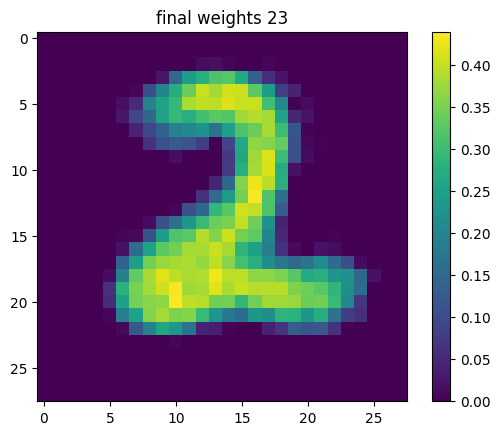

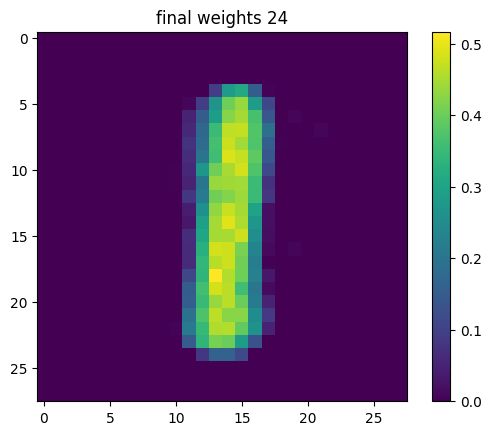

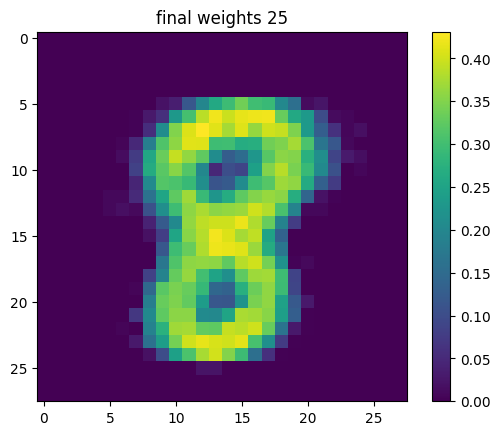

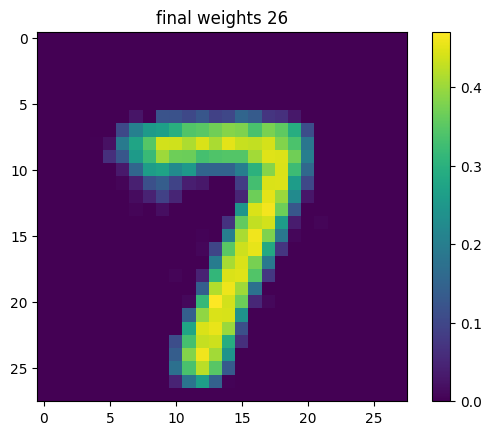

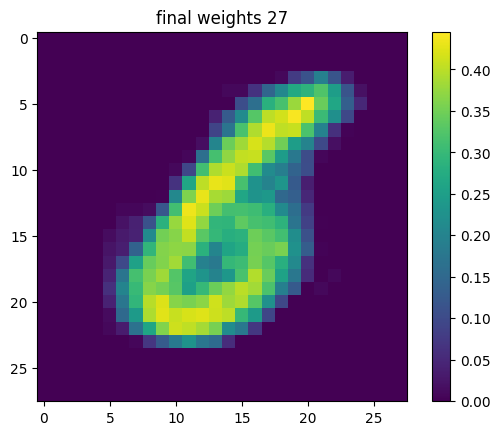

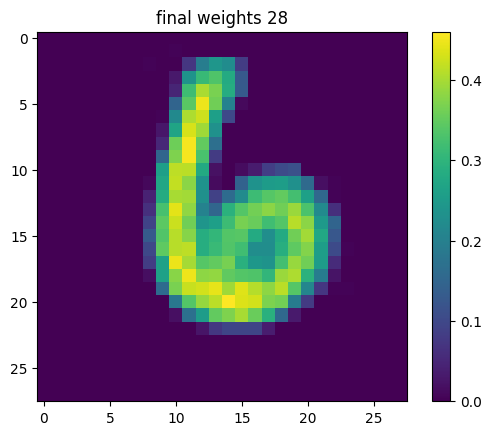

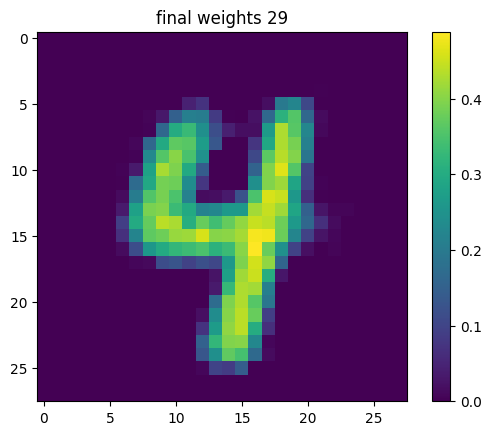

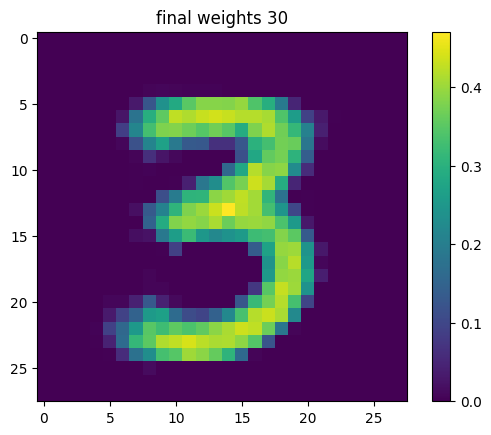

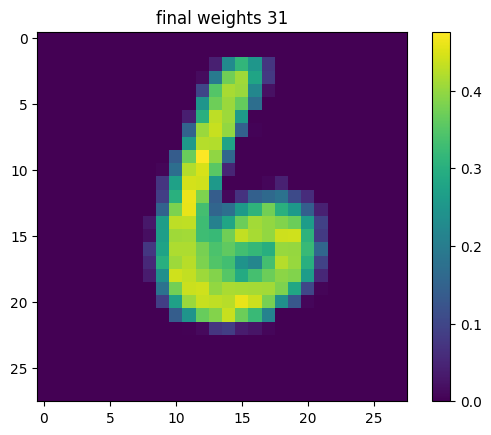

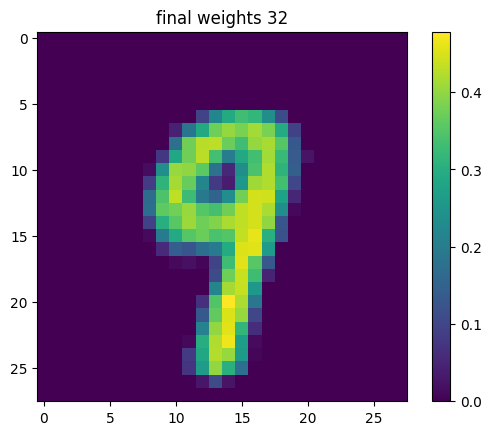

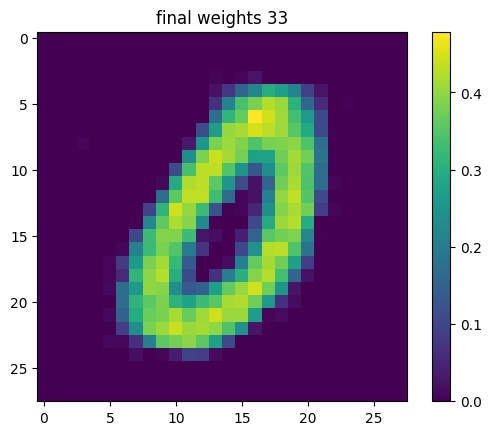

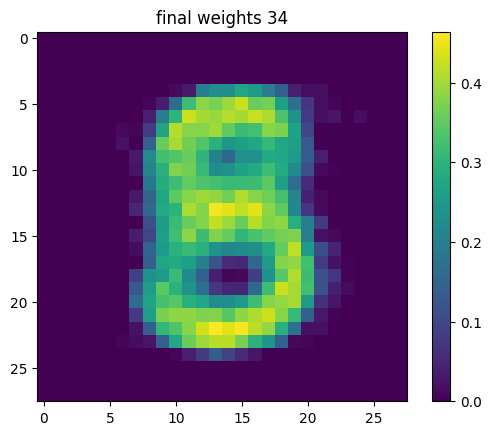

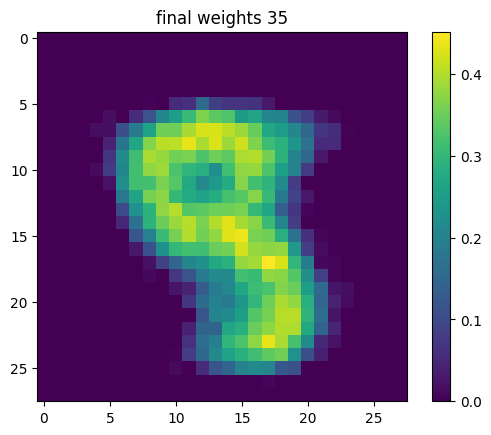

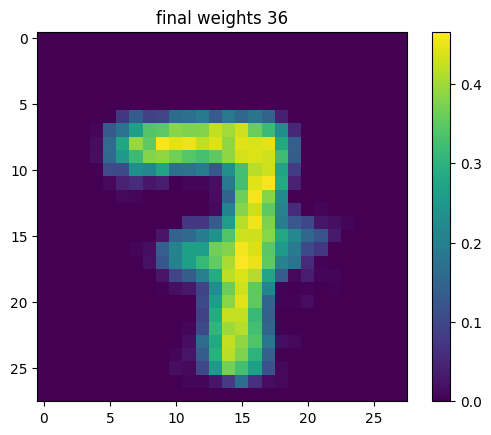

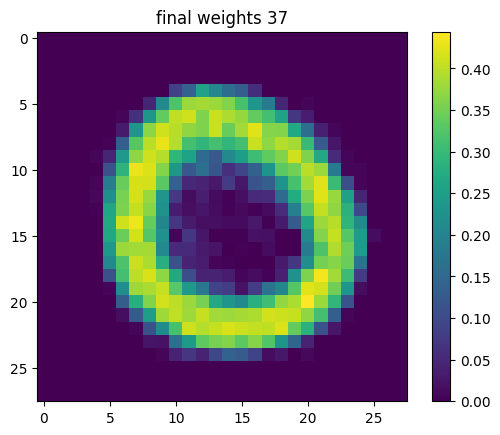

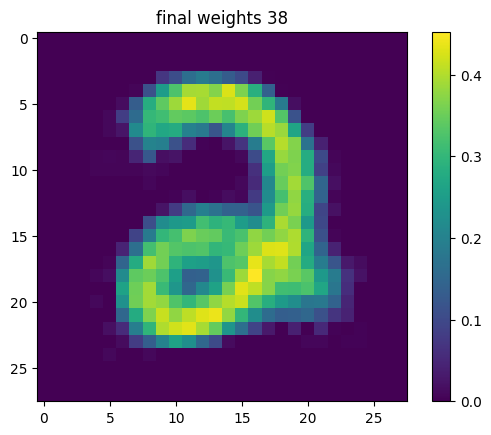

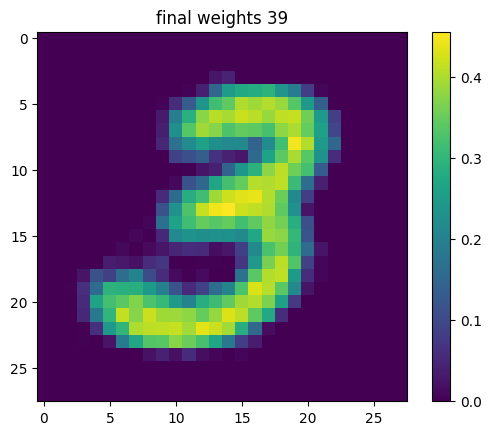

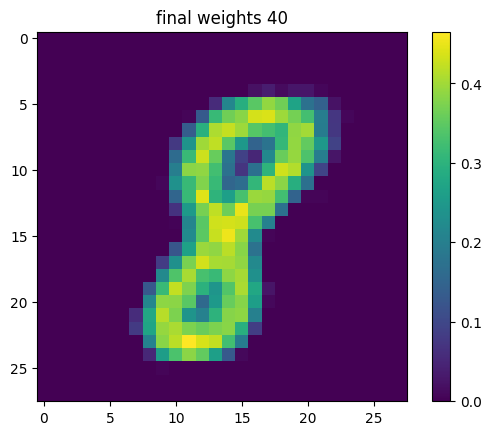

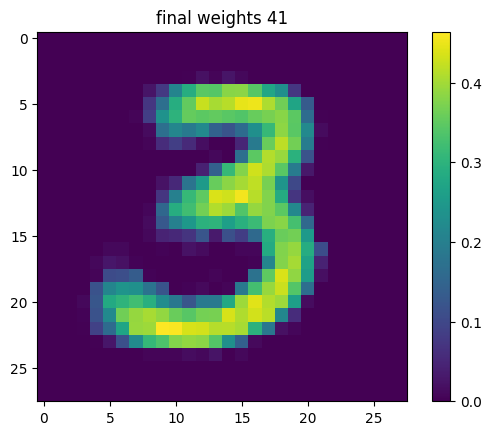

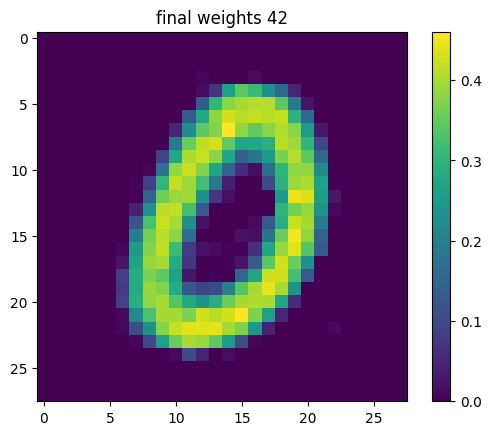

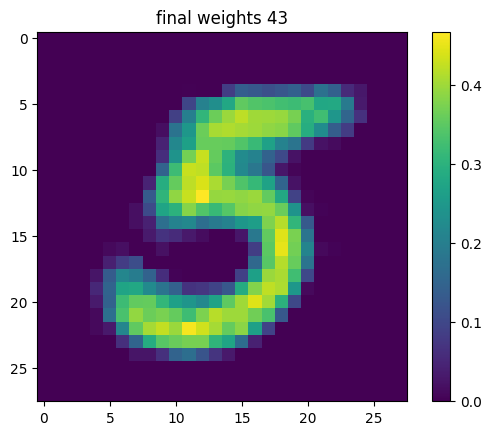

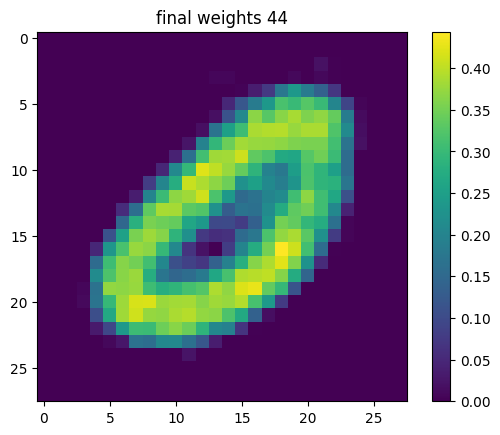

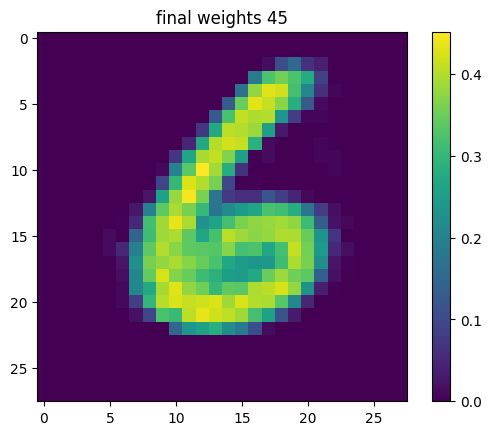

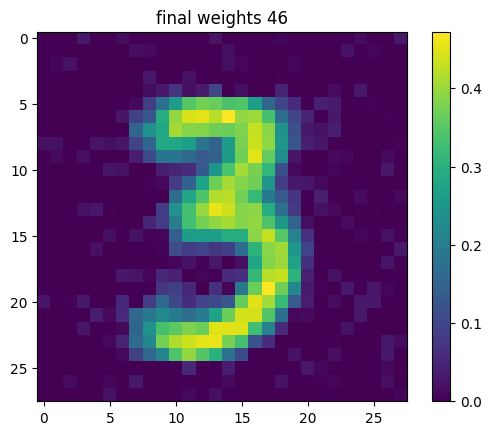

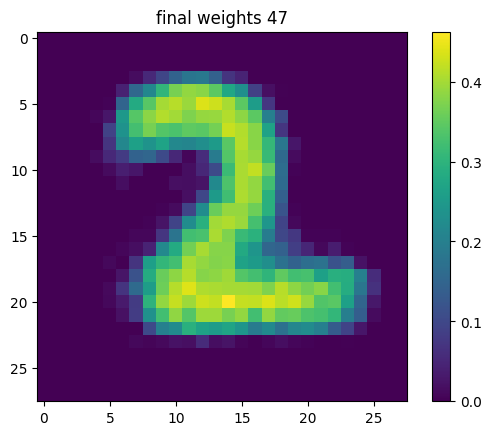

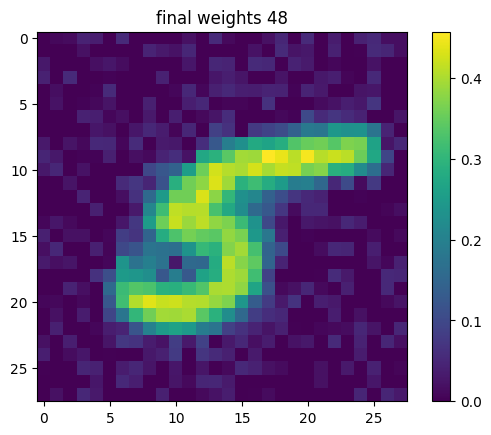

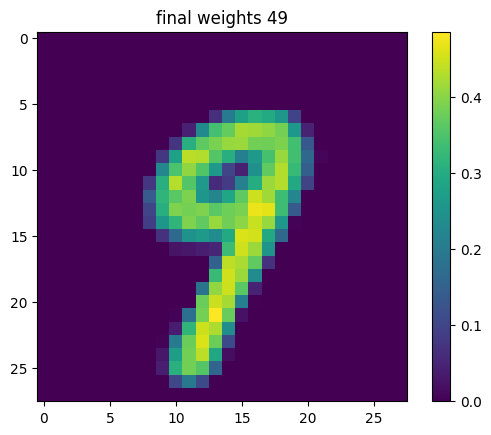

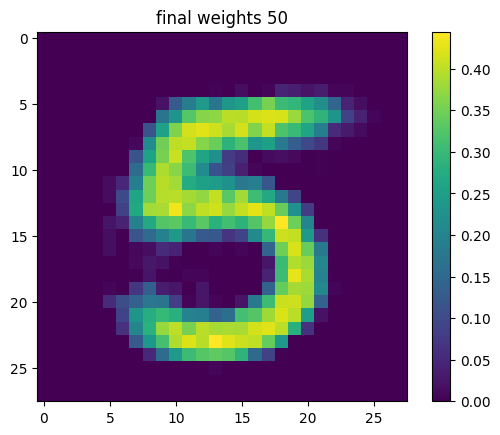

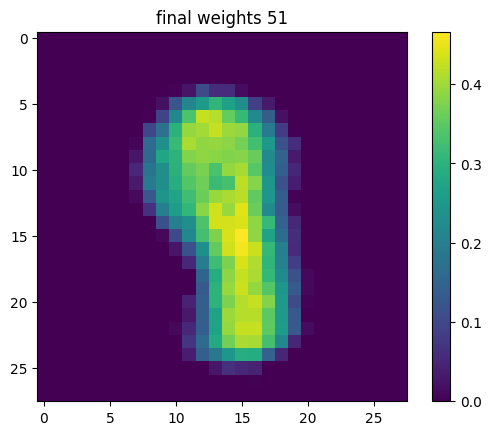

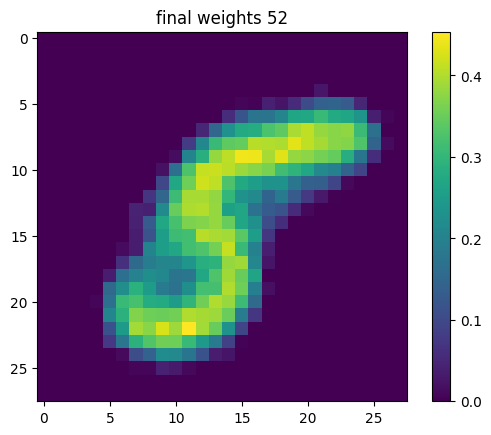

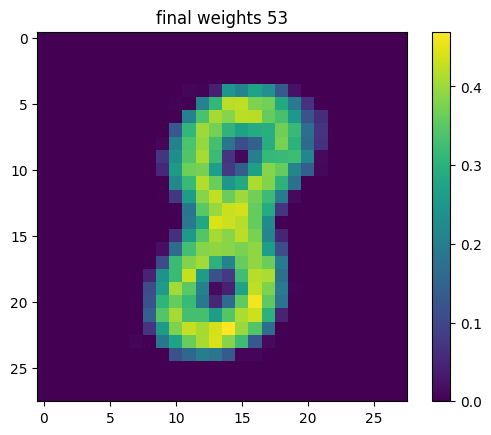

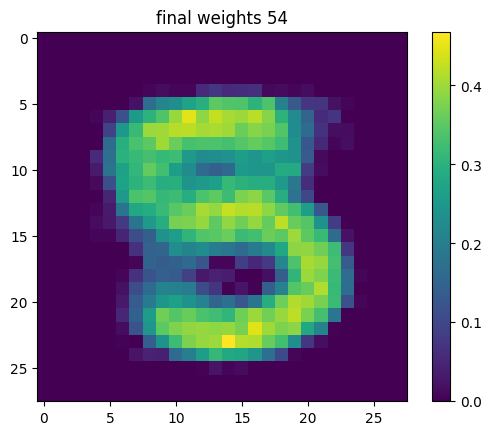

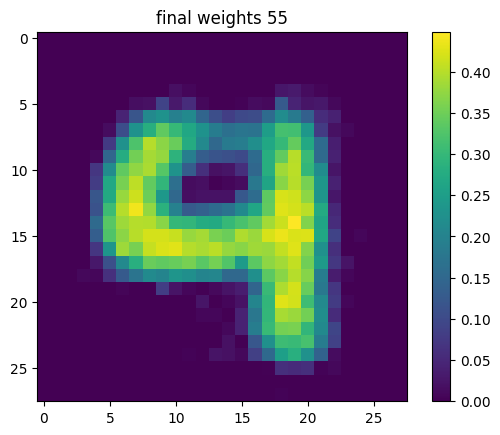

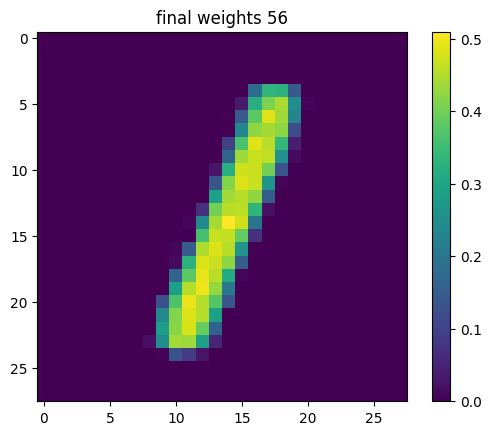

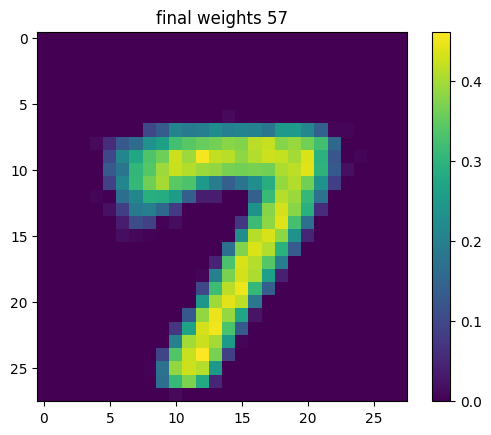

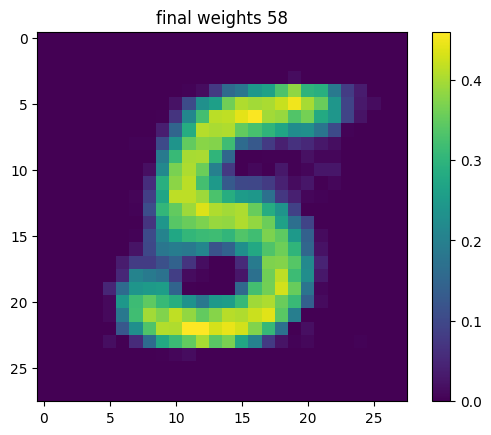

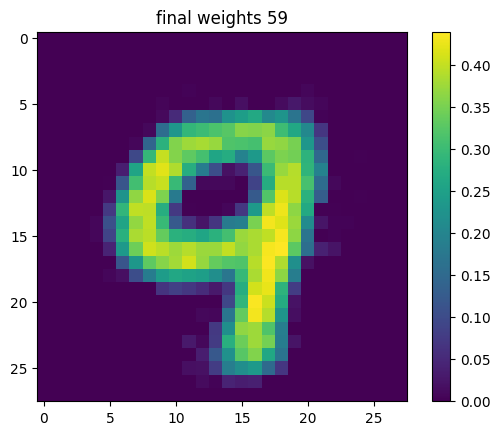

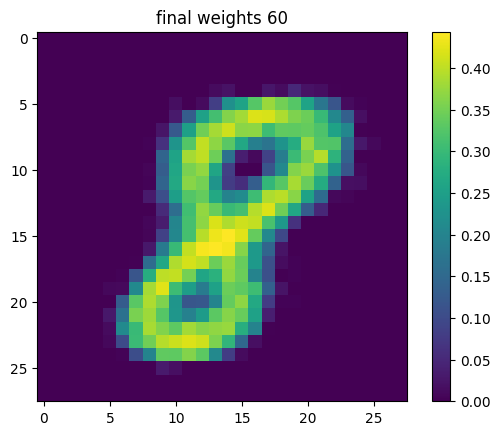

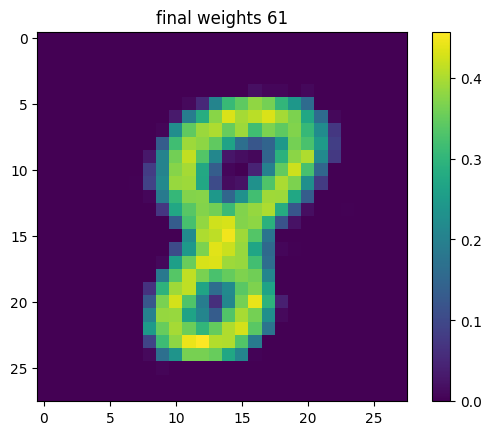

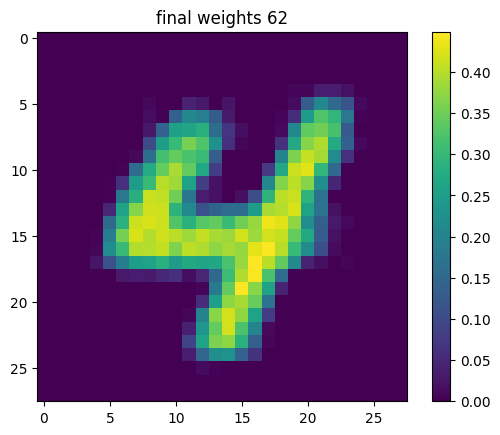

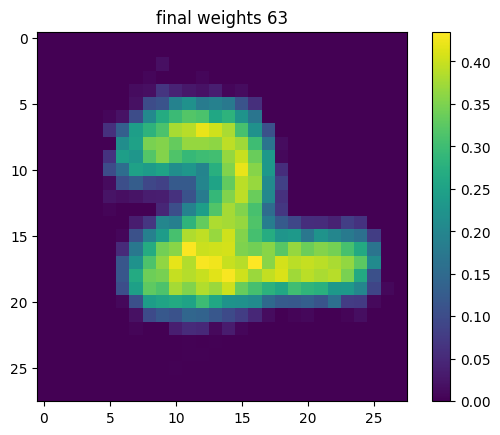

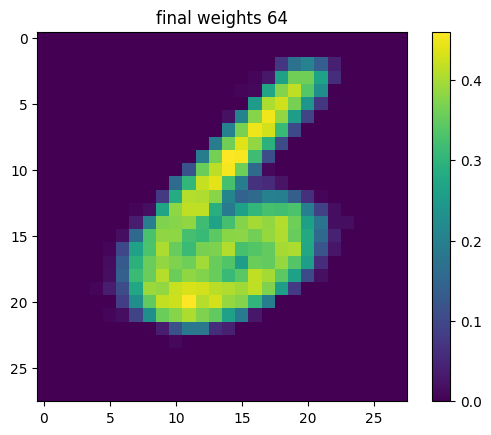

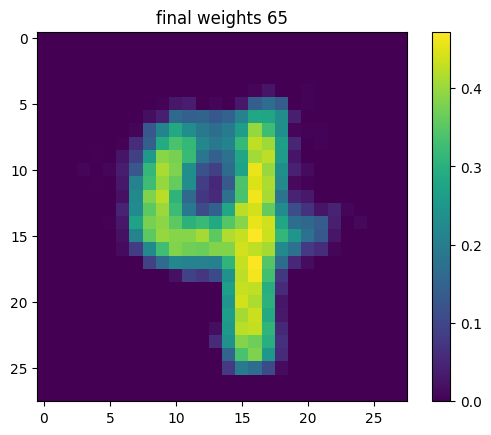

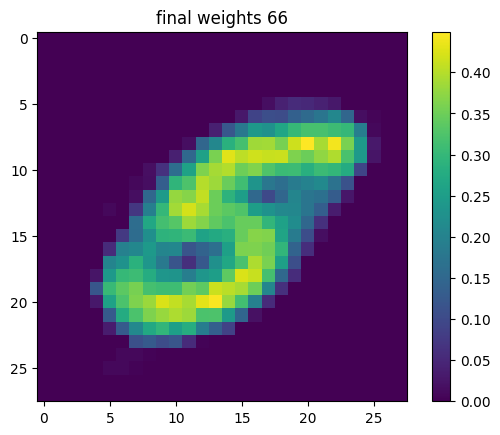

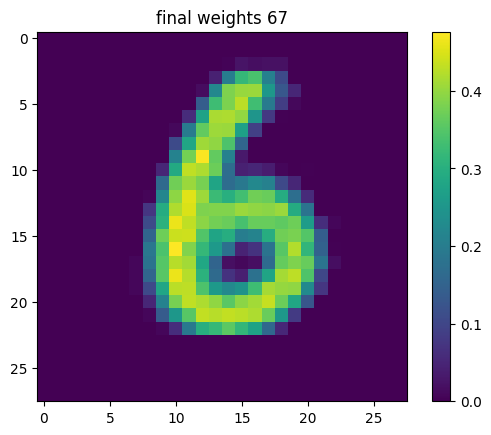

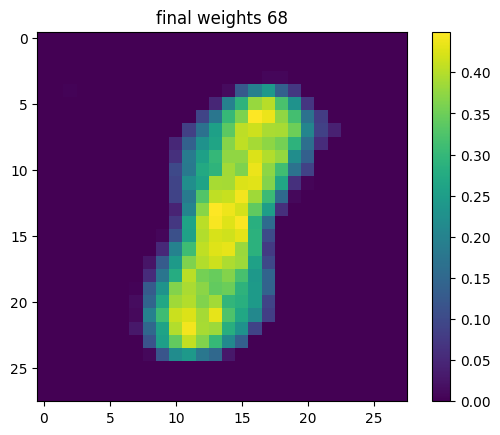

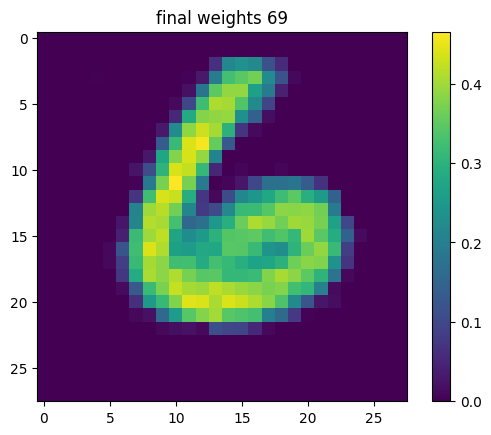

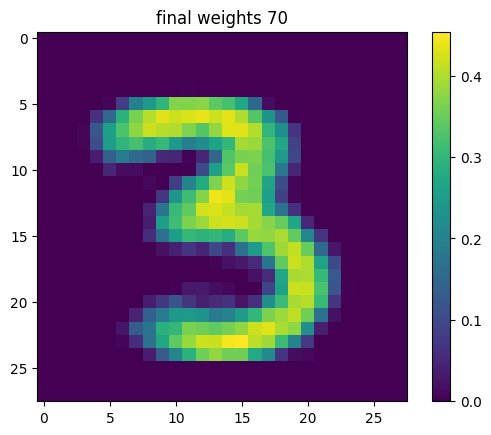

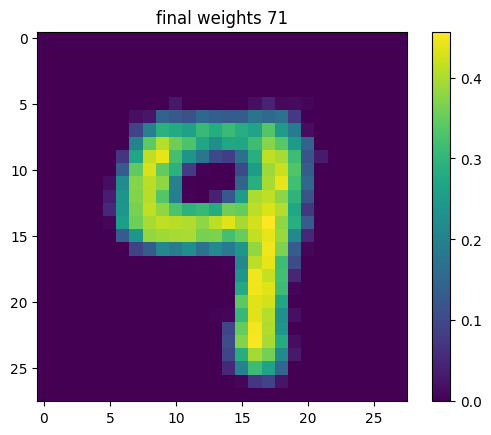

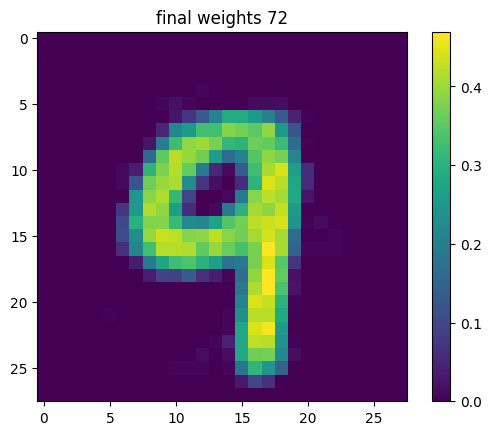

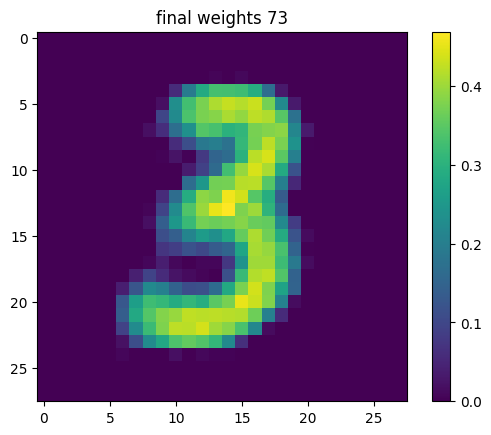

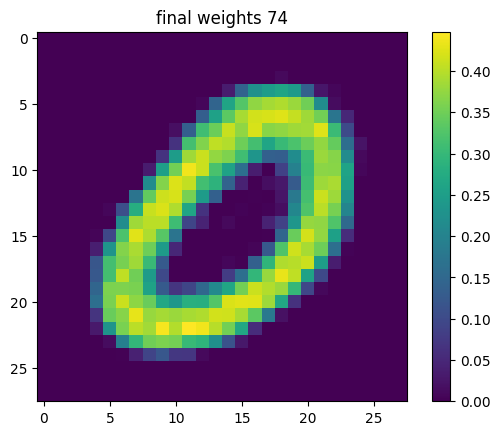

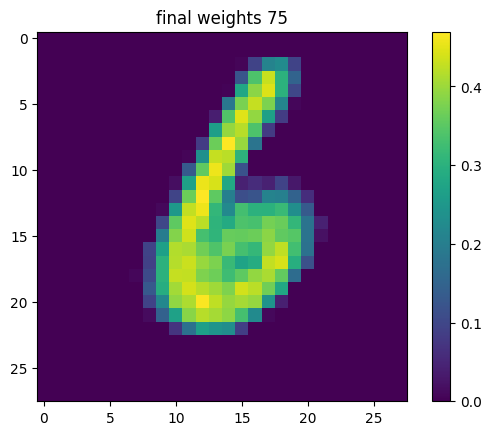

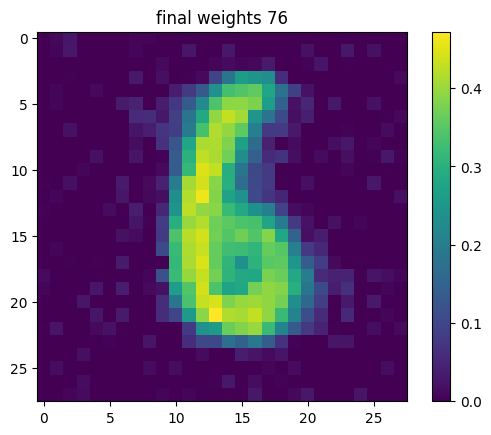

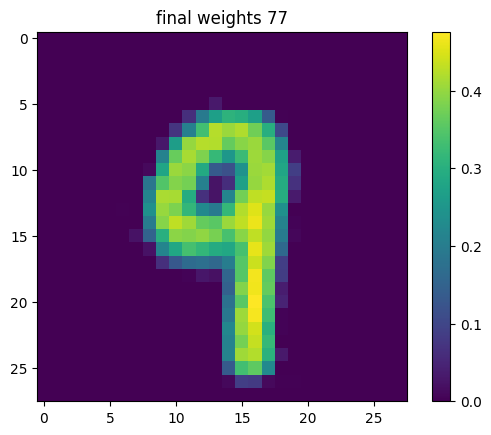

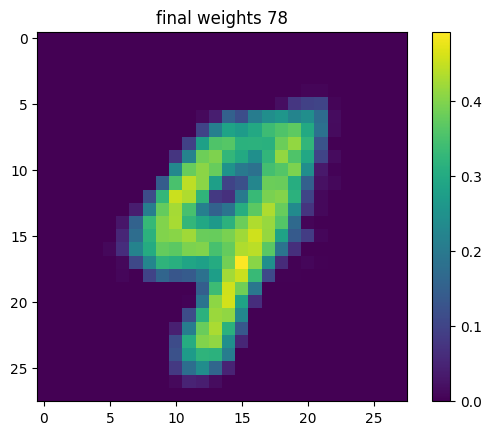

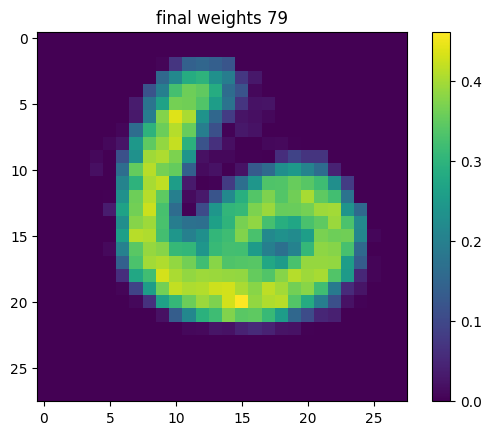

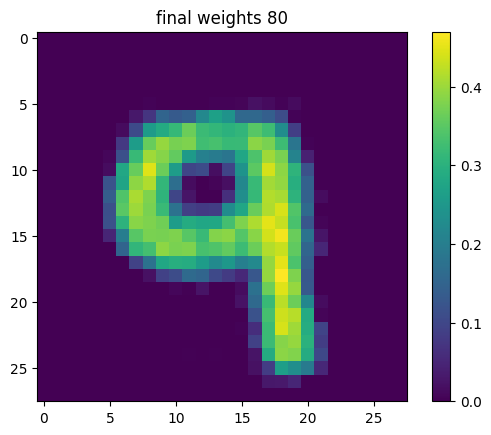

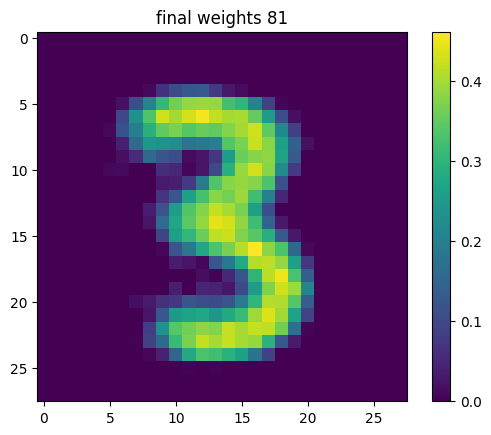

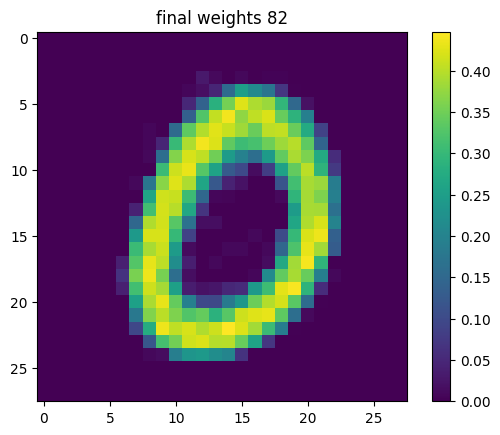

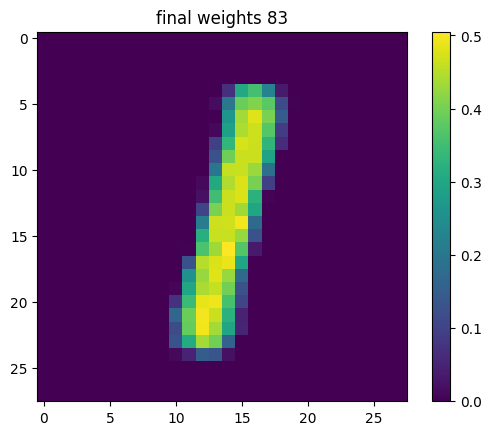

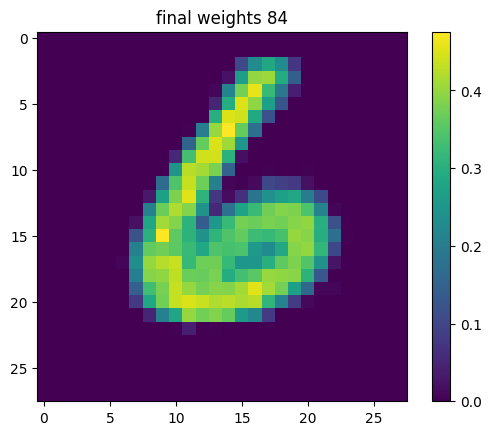

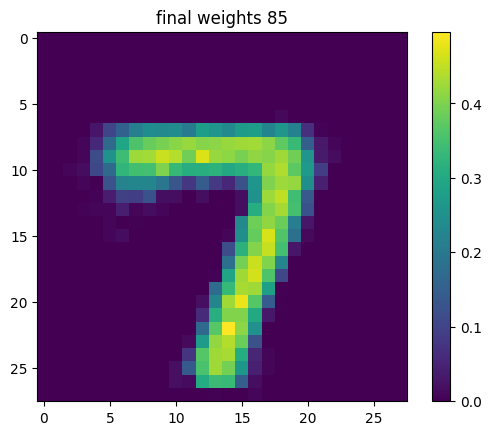

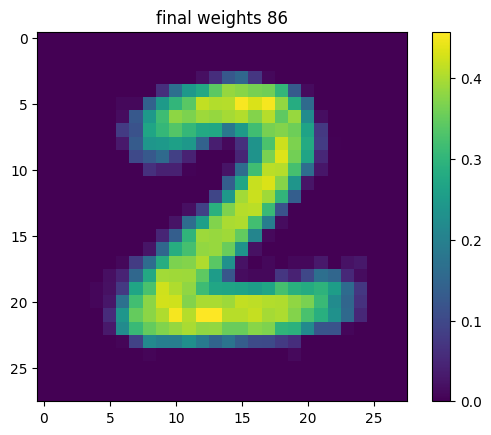

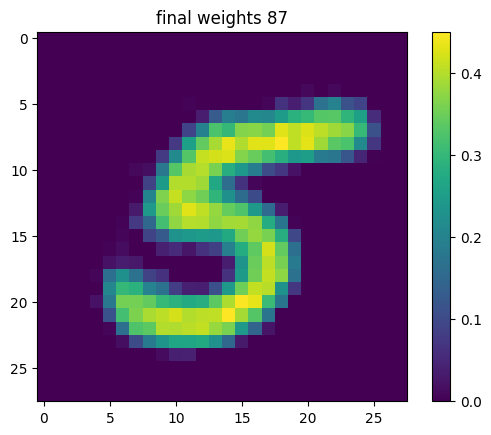

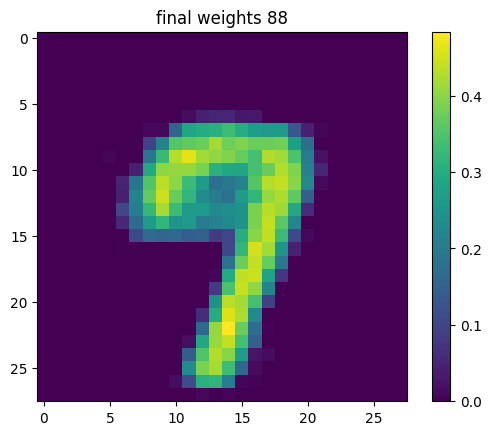

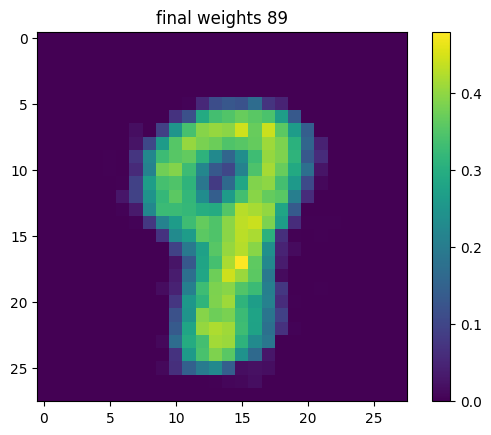

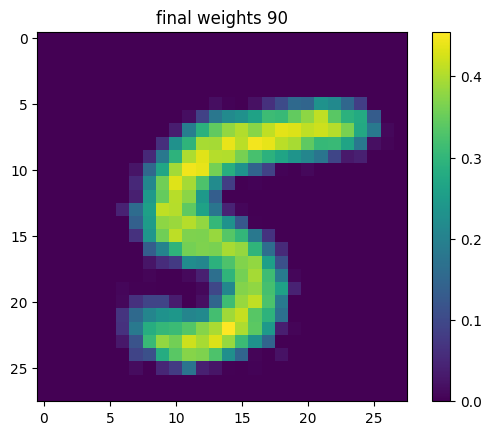

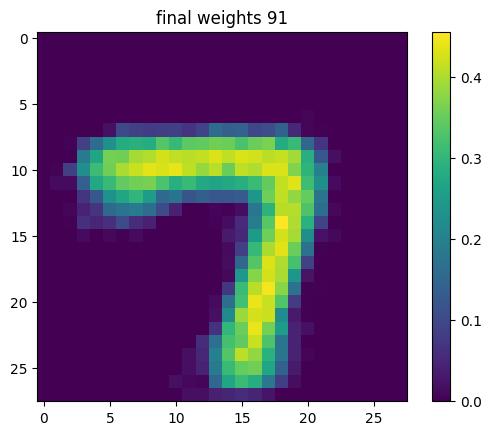

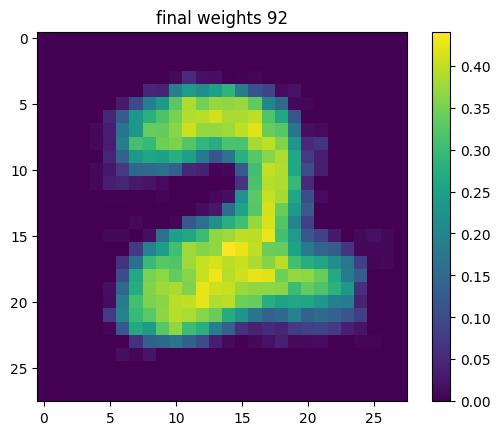

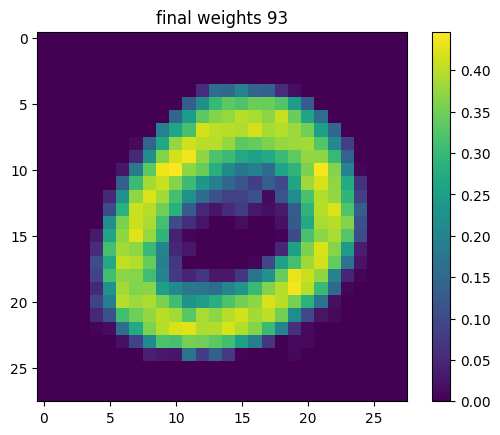

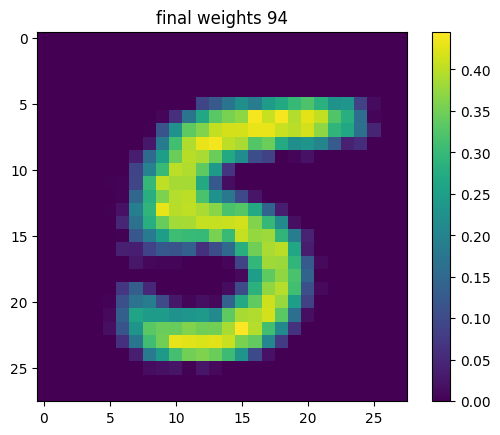

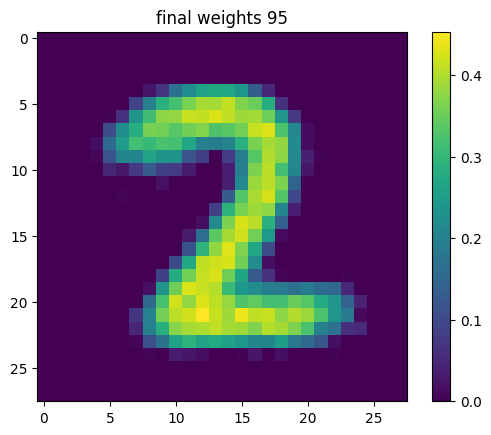

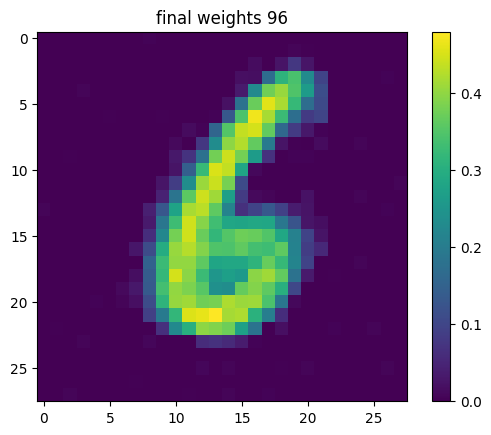

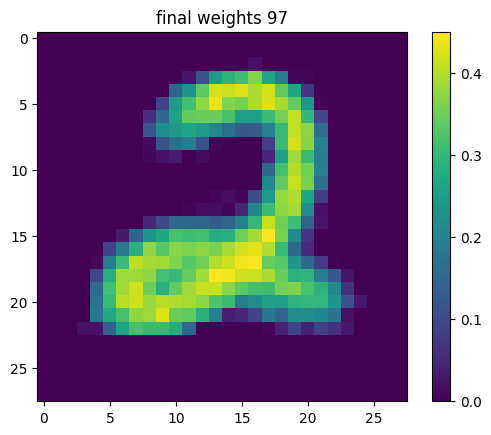

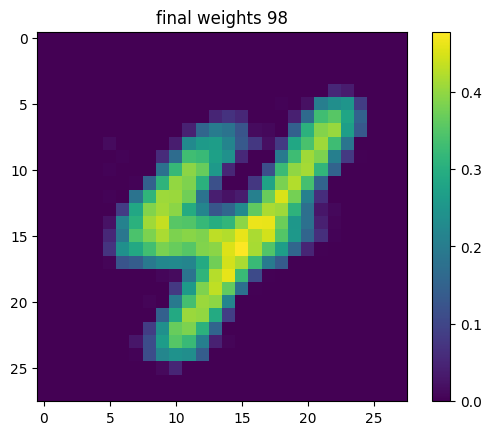

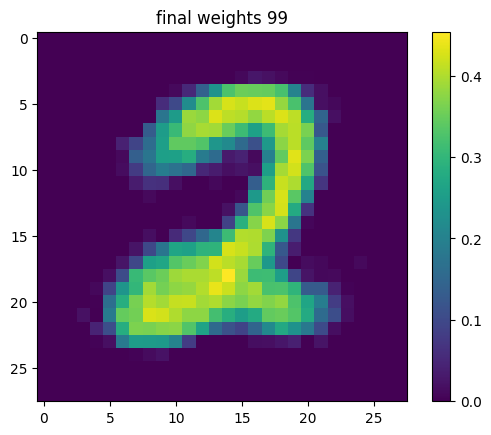

In [189]:
#BELOW WE LEARN THE HANDWRITTEN DIGITS WITH 60000 TRAINING STEPS
#try to learn the handwritten digits
neurons=InhibitedNeuronLayer(100, tau=100, v_reset=0.0, v_thresh=500, theta=1, tau_theta=0.0001)
synapses=SynapseLayer(784,neurons.size,alpha_plus=0.01,alpha_minus=-0.005,beta=3,min_weight=0,max_weight=1,spike_duration=25)
#show original weight matrices
for i in range(neurons.size):
    plt.figure()
    plt.imshow(synapses.weights[:,i].reshape((28,28)))
    plt.title(f'original weights {i}')
    plt.colorbar()
    plt.show()

#do some training on the neurons
training_time=60000
digits_presented=np.zeros(10)
digit_time=350
for i in range(training_time):
    #voltages of neurons in the SNN
    outputvoltages = np.zeros((neurons.size,digit_time),dtype=float)
    #spiking behavior of neurons in the SNN
    outputspikes = np.zeros((neurons.size,digit_time))
    digits_presented[y[i]]+=1
    inputs = np.abs(np.ravel(X[i])/4)
    inputs = np.reshape(inputs,(len(inputs),1)) #input data
    inputspikes=np.random.rand(inputs.shape[0],digit_time) #convert input data to spike trains
    inputspikes=inputspikes<inputs #convert input data to spike trains
    
    #feed in the spike train and allow the network to continuously update
    for j in range(digit_time):
        output_currents=(inputspikes[:,j].T@synapses.weights).T                 #calculate current to output neurons
        outputvoltages[:,j],outputspikes[:,j]=neurons.step(output_currents) #update voltages and spiking of output neurons
        if np.any(outputspikes[:,j]):
            synapses.update_weights(inputspikes[:,j],outputspikes[:,j])             #update synapses
        else:
            synapses.step() #no weight updates if there are no output spikes

    #show output voltages, output spikes
    # times=np.linspace(0,digit_time-1,digit_time)
    # print(f'digit presented at time {i}: {y[i]}')
    # plt.figure()
    # for j in range(neurons.size):
    #     plt.plot(times,outputvoltages[j,:],label=f'{j}')
    # plt.legend()
    # plt.title(f'voltages {i}')
    # plt.show()
    
    # plt.figure()
    # for j in range(neurons.size):
    #     plt.scatter(times,outputspikes[j,:],label=f'{j}')
    # plt.legend()
    # plt.title(f'spikes {i}')
    # plt.show()
    
    #after feeding one digit, let the network rest enough to allow the voltages and synaptic traces to decay back to their resting values
    neurons.reset()
    synapses.reset()

print('digits presented: ', digits_presented)
    
#show final weight matrices
for i in range(neurons.size):
    plt.figure()
    plt.imshow(synapses.weights[:,i].reshape((28,28)))
    plt.title(f'final weights {i}')
    plt.colorbar()
    plt.show()

In [190]:
#now classify which digit each neuron belongs to
neurons1=InhibitedNeuronLayer(100, tau=100, v_reset=0.0, v_thresh=500, theta=1, tau_theta=0.0001)
neurons1.v_thresh=np.copy(neurons.v_thresh)
classification_time=10000
spike_frequencies=np.zeros((neurons1.size,10))
digit_time=350
digits_presented=np.zeros(10)
for i in range(classification_time):
    #voltages of neurons in the SNN
    outputvoltages = np.zeros((neurons1.size,digit_time),dtype=float)
    #spiking behavior of neurons in the SNN
    outputspikes = np.zeros((neurons1.size,digit_time))
    digits_presented[y[i]]+=1
    inputs = np.abs(np.ravel(X[i])/4)
    inputs = np.reshape(inputs,(len(inputs),1)) #input data
    inputspikes=np.random.rand(inputs.shape[0],digit_time) #convert input data to spike trains
    inputspikes=inputspikes<inputs #convert input data to spike trains
    
    #feed in the spike train and allow the network to continuously update
    for j in range(digit_time):
        output_currents=(inputspikes[:,j].T@synapses.weights).T                 #calculate current to output neurons
        outputvoltages[:,j],outputspikes[:,j]=neurons1.static_step(output_currents) #update voltages and spiking of output neurons
        spike_frequencies[:,y[i]]+=outputspikes[:,j]
        
    #after feeding one digit, let the network rest enough to allow the voltages and synaptic traces to decay back to their resting values
    neurons1.reset()

In [191]:
neuron_ids=np.argmax(spike_frequencies,axis=1)

#now estimate accuracy
test_time=10000
confusion_matrix=np.zeros((10,10))
digit_time=350
digits_presented=np.zeros(10)
correct_predictions=0
for i in range(test_time):
    #voltages of neurons in the SNN
    outputvoltages = np.zeros((neurons1.size,digit_time),dtype=float)
    #spiking behavior of neurons in the SNN
    outputspikes = np.zeros((neurons1.size,digit_time))
    digits_presented[y[i+60000]]+=1
    inputs = np.abs(np.ravel(X[i+60000])/4)
    inputs = np.reshape(inputs,(len(inputs),1)) #input data
    inputspikes=np.random.rand(inputs.shape[0],digit_time) #convert input data to spike trains
    inputspikes=inputspikes<inputs #convert input data to spike trains
    
    #feed in the spike train and allow the network to continuously update
    for j in range(digit_time):
        output_currents=(inputspikes[:,j].T@synapses.weights).T                 #calculate current to output neurons
        outputvoltages[:,j],outputspikes[:,j]=neurons1.static_step(output_currents) #update voltages and spiking of output neurons

    #determine the neuron with which this digit is most associated
    neuron_id_test=np.argmax(np.sum(outputspikes,axis=1))
    predicted_digit=neuron_ids[neuron_id_test]
    correct_digit=y[i+60000]
    if predicted_digit==correct_digit:
        correct_predictions+=1
    confusion_matrix[predicted_digit,correct_digit]+=1
    
    #after feeding one digit, let the network rest enough to allow the voltages and synaptic traces to decay back to their resting values
    neurons1.reset()

accuracy=correct_predictions/test_time #determine accuracy
confusion_matrix = confusion_matrix/digits_presented #normalize confusion matrix

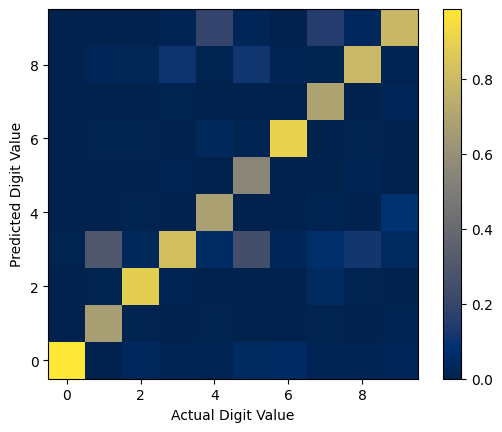

[ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]
0.7779


In [192]:
#plot confusion matrix
plt.figure()
plt.imshow(confusion_matrix,origin='lower',cmap='cividis')
plt.xlabel('Actual Digit Value')
plt.ylabel('Predicted Digit Value')
plt.colorbar()
plt.show()

print(digits_presented)
print(accuracy)